This document pulls the latest aggregated data for the COVID-19 outbreak in the US and performs some basic analysis. It is free to use and contributions are welcome.

## Commentary

This experiment in data science was inspired by a single YouTube video posted by Grant Sanderson related to the matter. Grant is a graduate of Stanford and was a contributor at the Khan Academy in the topics of multivariable calculus. Thanks for the adventure, Grant!

Consuming the entire data set introduces lots of uncertainty to some of the graphs. This is largely due to the pattern of growth not being well established in the early days. I set a parameter ```start_date``` to set the point at which the graphs are built. Visual inspection reveals the data stablilizes around March 20, depending on the state.

Growth factor is a measure of inter-day growth and is calculated as follows:

    Growth Factor == Cases Today / Cases Yesterday

"Possible Growth Turn" is the point where Growth Factor is predicted to be 1.0 (e.g. 0%). This is the point where the rate of new confirmed cases may be turning from an exponential growth curve. This may also predict that we are entering a phase of recovery. 

Other measures made it in, all derived from the same data. If you have a specific metric or region you'd like to see please feel free to reacho out. @schwim will do at the usual locations.

## Definitions

 - Mortality Rate = death / positive
 - Positive Daily = Number of daily positive tests counted (duh)
 - Negative Daily = Those that were tested but negative
 - Daily Deaths = How many died per day
 - Hospitalized Daily = How many people that are positive and were hospitalized per day - this is unconfirmed, as it's unclear as to whether positive correlates with this number
 - Recovered Daily - rarely counted and probably innacurate as we tend to forget about non-problems
 - Positive Growth - did you read the above?!? % increase/decreas in positive tests vs. yesterday.
 - Death Growth - think about it...

Others are in the work. If you look at the code you'll see what I'm after. I slow rolled these as I've not found any of them to be revealing of anything beyond political banter, which is not the purpose of this effort.

## Disclaimer

I am not an expert in data analysis and am only providing this for anyone that might find casual interest in my work on this. 

DO NOT REFERENCE THIS ANALYSIS FOR DECISION MAKING!

References:
 - Exponential growth and epidemics - 3Blue1Brown - https://www.youtube.com/watch?v=Kas0tIxDvrg&t=1s
 - Simulating an epidemic - 3Blue1Brown - https://www.youtube.com/watch?v=gxAaO2rsdIs
 - Why outbreaks like coronavirus spread exponentially, and how to “flatten the curve” - Harry Stevens @ The Washington Post - https://www.washingtonpost.com/graphics/2020/world/corona-simulator/
 - John Hopkins data repository - https://github.com/CSSEGISandData/COVID-19
 - https://covidtracking.com/api/v1/us/daily.json

Thank you to the professional mathemeticians and data scientists whom I consulted on this adventure. I learned a lot and your guidance was priceless. I owe you lots of beer.

This work is 100% Python. Who needs R? 

Author: Greg Schwimer

In [1]:
# Knobs. Everyone likes a knob or two!

# Use this if you want to look at a state
# default to 'US', otherwise use state e.g. 'Arizona' or 'New York'
state = 'Arizona' 

# Adjust to the start date. Data goes back to 1/1/20
start_date = '04/20/20'

# Adjust the end date if desired
end_date = 'Today'

# Do we report all states, or set a region of interest (ROI)
reportAll = False # <-- this is a huge page, you're welcome to ask me for a copy
roi = ['AZ', 'US', 'TX', 'CA', 'FL']

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import os

state_info = pd.read_csv('./population_data.csv', usecols=['area', 'population'], index_col='area')

In [3]:
# some set up

# gets the data from CovidTracking.com.
def getDataCovidTracking(get_states=False):
    
    if get_states is False:
        url = 'https://covidtracking.com/api/v1/us/daily.json'
    else:
        url = 'https://covidtracking.com/api/v1/states/daily.json'
        
    locations = {'us': '', 'states': ''}
        
    for x, location in enumerate(locations):
        
        url = 'https://covidtracking.com/api/v1/{}/daily.json'.format(location)
        
        data = pd.read_json(url)    
    # fix the dates
        data.loc[:, 'date'] = data.date.apply(str)
        data.loc[:, 'date'] = data.date.apply(lambda x: '{}-{}-{}'.format(x[4:6],x[6:8],x[0:4]))
        data = data.set_index('date').sort_index()
        locations[location] = data
    
    return locations

def pltStats(title=None, cols=[], scale='linear', data=None, marker=None):
    
    if data is None:
        print('Data needs to be fed here.')
        return

    # set up the framework
    fig = plt.figure(figsize=(16,12))
    ax = fig.add_subplot(111)
    ax.set_yscale(scale)

    # add the plots
    for n, col in enumerate(cols):
        
        ax.plot(data[col])
    

    ### if marker is not None:
    #maxX = data.max().max()
#     ax.add_line('06-01-2020', 0, 1000, label='Protests Start')
    
    # adjust the tics on the x axis
    every_nth = 4
    for n, label in enumerate(ax.xaxis.get_ticklabels()):
        if n % every_nth != 0:
            label.set_visible(False)
    plt.xticks(rotation=45)
    
    # legendary, this part...
    plt.legend(cols, shadow=True, loc='upper left')
    plt.title('{}'.format(title), fontsize='xx-large')
    plt.grid(axis='y')
    plt.show()

    
def makeStats(data=None, state_info=state_info):
    
        df = data
        
        df.loc[:, 'mortalityRate'] = (df.death / df.positive) * 100
    
        # daily delta = today - yesterday then smooth with a rolling 3 mean
        r = 7
        df.loc[:, 'positiveDaily'] = (df.positive - df.positive.shift()).rolling(r).mean()
        df.loc[:, 'negativeDaily'] = (df.negative - df.negative.shift()).rolling(r).mean()
        df.loc[:, 'deathDaily'] = (df.death - df.death.shift()).rolling(r).mean()
        df.loc[:, 'hospitalizedDaily'] = (df.hospitalizedCurrently - df.hospitalizedCurrently.shift()).rolling(r).mean()
        df.loc[:, 'hospitalizedDaily2'] = (df.hospitalizedCurrently - df.hospitalizedCurrently.shift())
        df.loc[:, 'recoveredDaily'] = (df.recovered - df.recovered.shift()).rolling(r).mean()
        df.loc[:, 'positiveRatioDaily'] = df.positiveDaily / (df.recoveredDaily + df.positiveDaily)

        # Growth factor = today / yesteday then take a rolling 7 mean.
        r = 7
        df.loc[:,'positiveGrowth'] = (df.positive / df.positive.shift()).rolling(r).mean()
        df.loc[:,'positiveGrowthRaw'] = df.positive / df.positive.shift()
        df.loc[:, 'deathGrowth'] = (df.death / df.death.shift()).rolling(r).mean()
        
        
        try:
        
            # per 1M pop stats
            df.loc[:, 'positivePer1M'] = df.positive / (state_info.loc[df.state].values[0] / 1000000)
            df.loc[:, 'deathPer1M'] = df.death / (state_info.loc[df.state].values[0] / 1000000)
            df.loc[:, 'deathDailyPer1M'] = df.deathDaily / (state_info.loc[df.state].values[0] / 1000000)

        except:
            pass
        
        return df


def makeReport(reports=None, data=None, start_date=None):

        # need to make the stats first
#         data = makeStats(data=data)
        
        # make the graphs
        for title, cols in reports.items():
            print('{} - {} - {}'.format('#' * 20, location, '#' * 20))
            title = '{} - {}'.format(location, title)
            pltStats(title=title, cols=cols, data=data[data.index >= start_date])
            
def makeStatesCompareReport(reports=None, data=None, roi=None, scale='linear', start_date=None):
    
    dfg = data
        
    if roi is not None:
        
        roiZones = pd.DataFrame()

        for state in roi:
            roiZones = roiZones.append(dfg.get_group(state))
            
        dfg = roiZones.groupby(by='state')
    
        
    for title, col in reports.items():
        
        # set up the framework
        fig = plt.figure(figsize=(16,12))
        ax = fig.add_subplot(111)
        ax.set_yscale(scale)    
    
        
        for state, data in dfg:
                        
            # plot the bitch
            ax.plot(data.loc[data.index >= start_date, col], label=state)
    
        every_nth = 4
        for n, label in enumerate(ax.xaxis.get_ticklabels()):
            if n % every_nth != 0:
                label.set_visible(False)
        plt.xticks(rotation=45)

        # legendary, this part...
        plt.legend(shadow=True, loc='upper left', bbox_to_anchor=(1.05, 1))
        plt.title('{}'.format(title), fontsize='xx-large')
        plt.grid(axis='y')
        plt.show()

In [4]:
# get the data
us, allStates = getDataCovidTracking().values()

# put it all in an dict so we end up with location: data that we can iterate through:
states = {'US': us}

# split out the states we want and add them to the dict
for x, y in enumerate(allStates.state.unique()):
    thisState = allStates.loc[allStates['state'] == y, :]
    states[y] = thisState

Looking here!
#################### - US - ####################


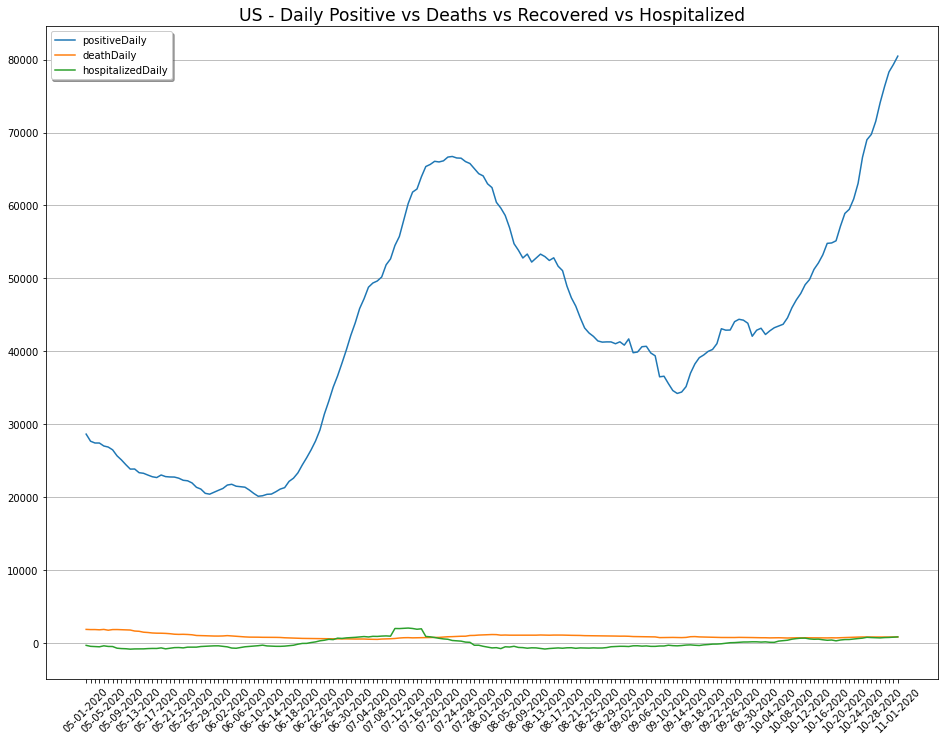

#################### - US - ####################


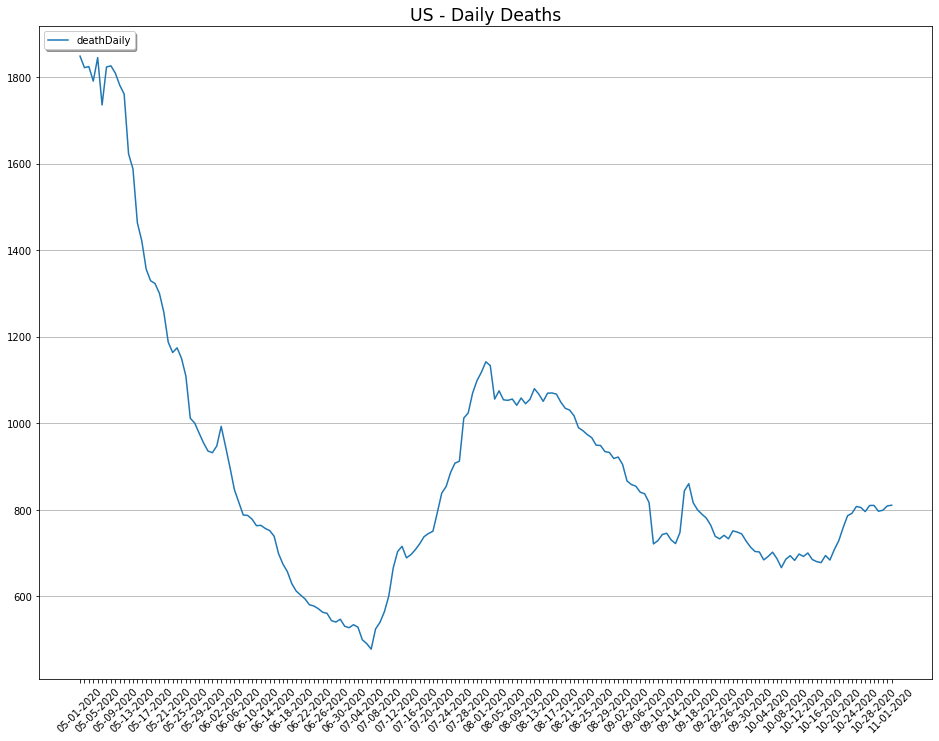

#################### - US - ####################


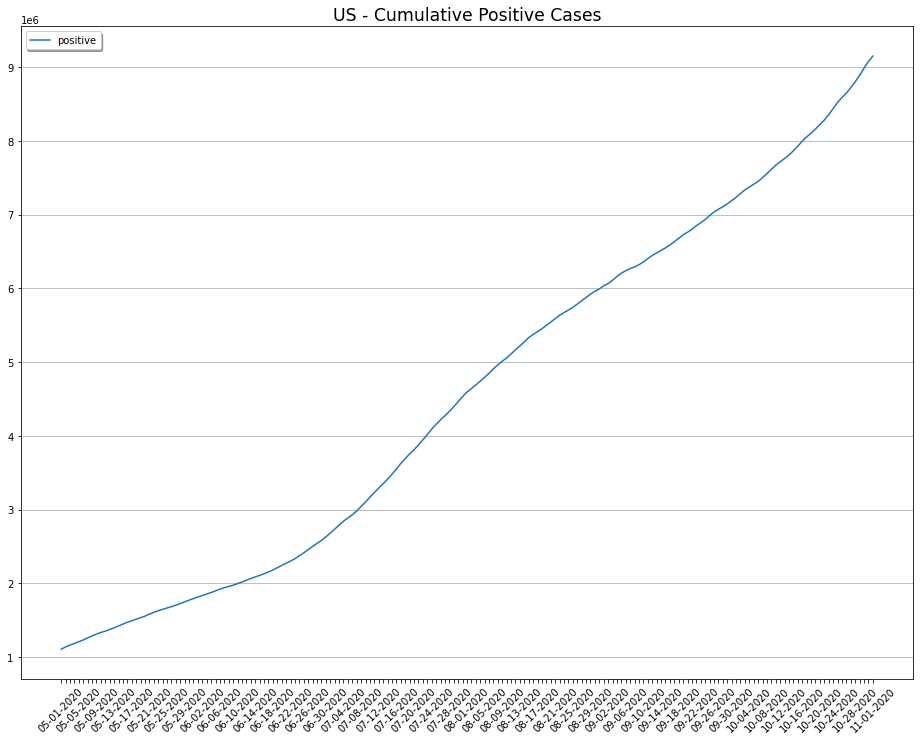

#################### - US - ####################


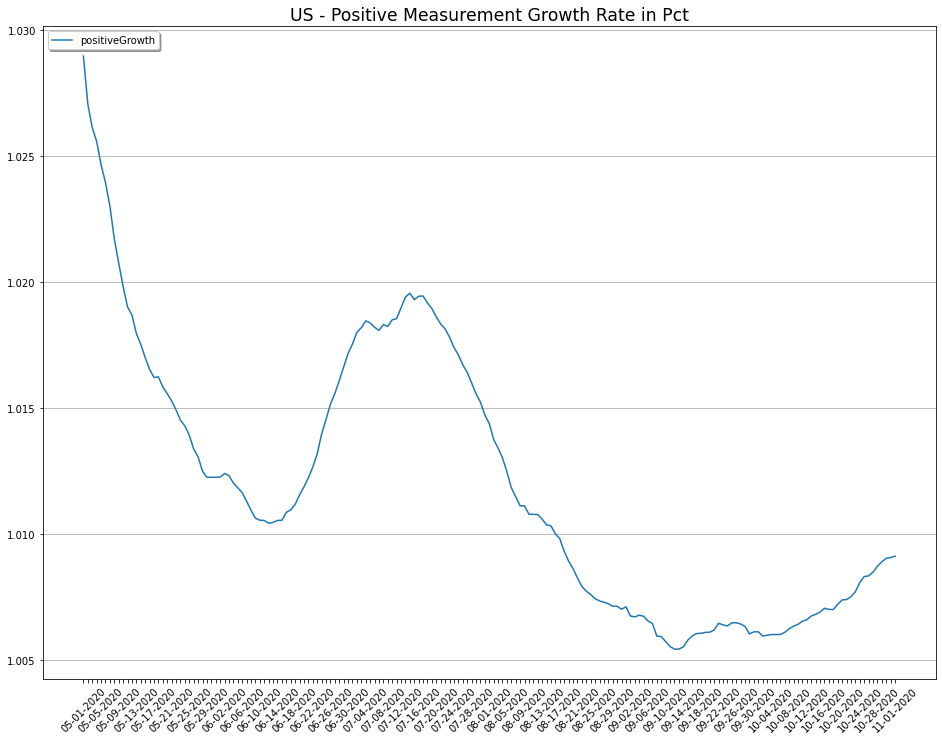

#################### - US - ####################


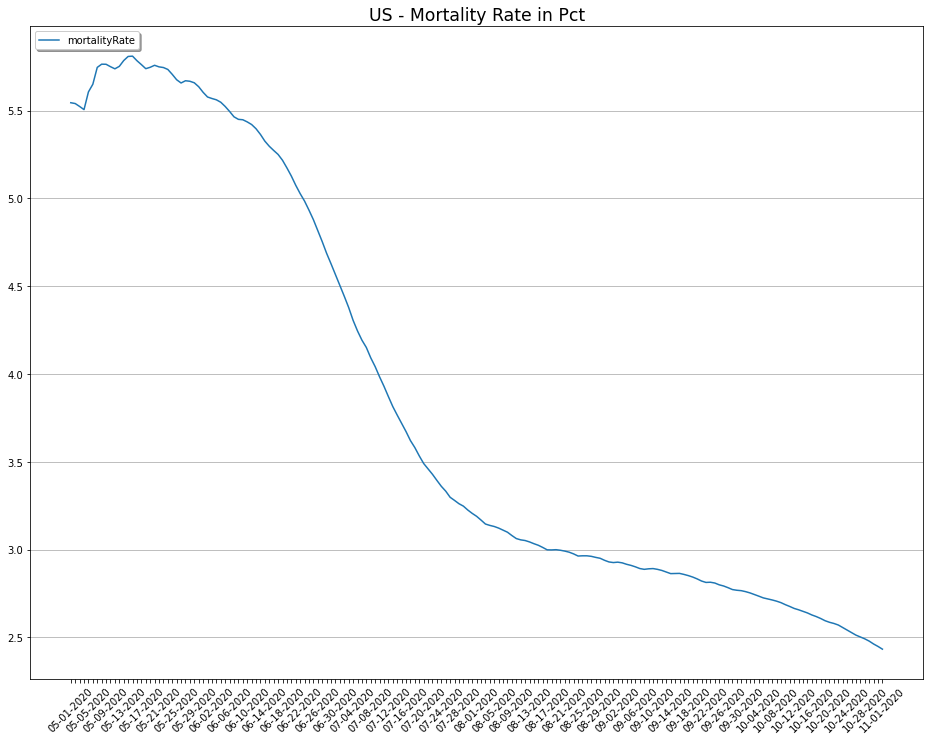

#################### - US - ####################


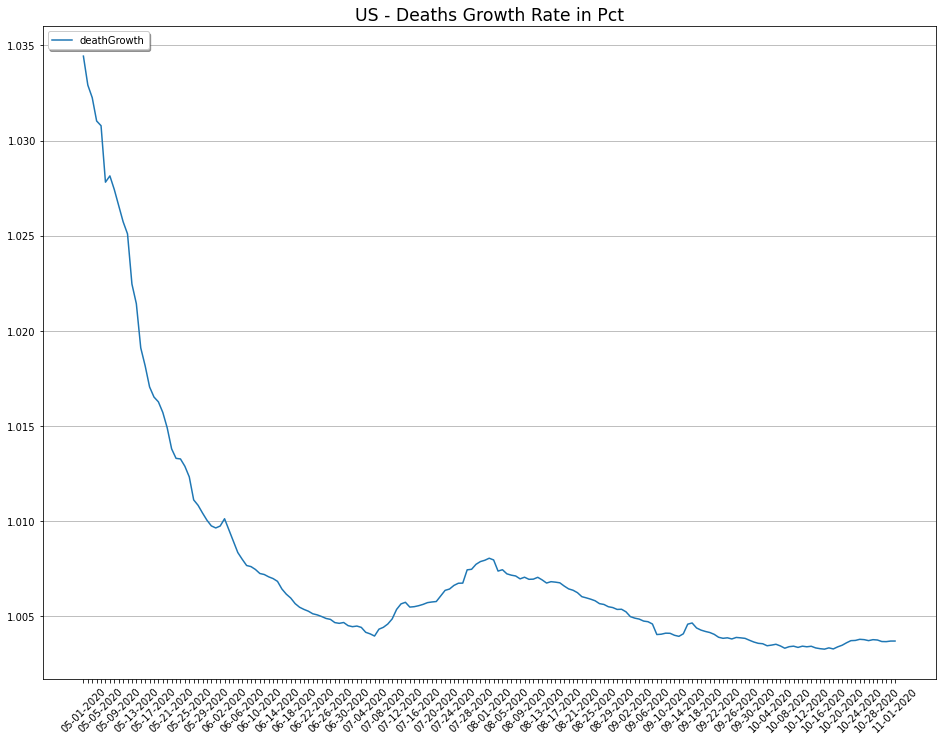

#################### - US - ####################


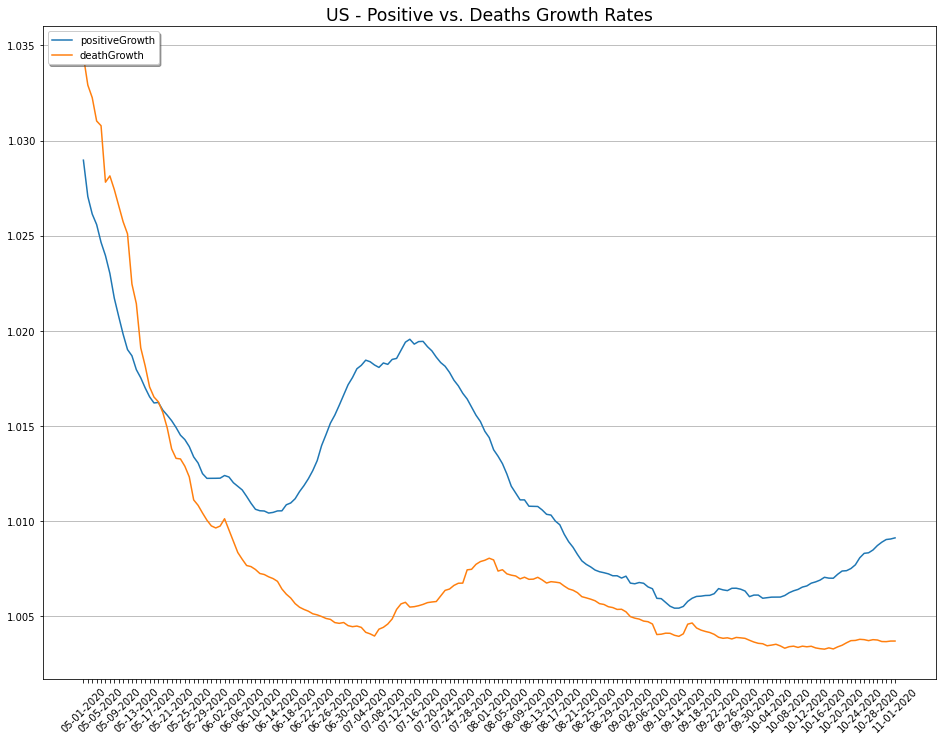

#################### - US - ####################


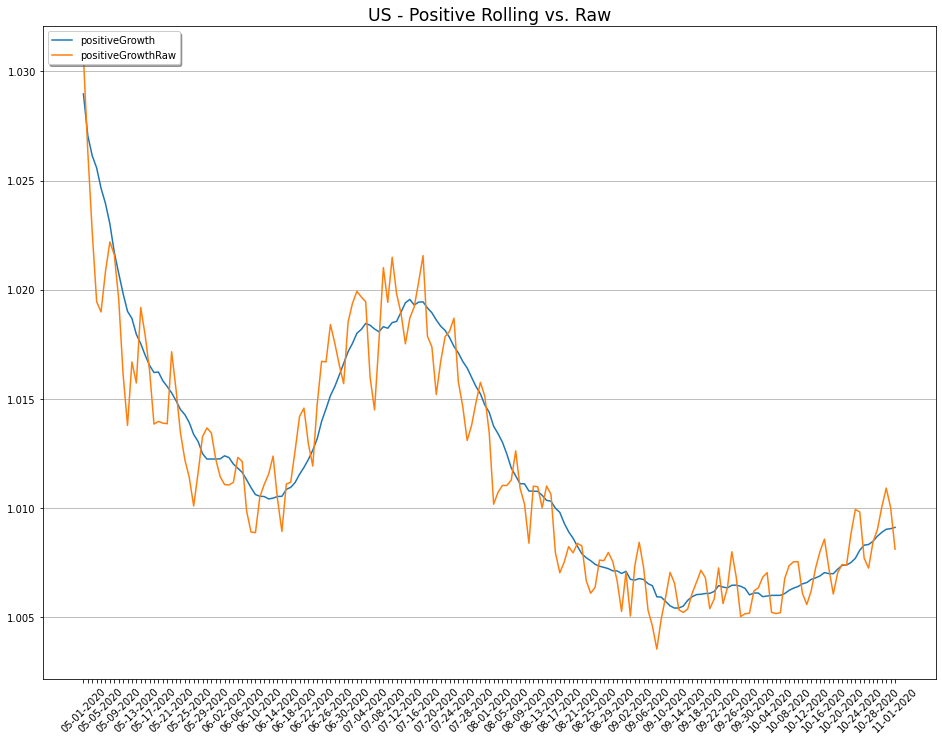

#################### - US - ####################


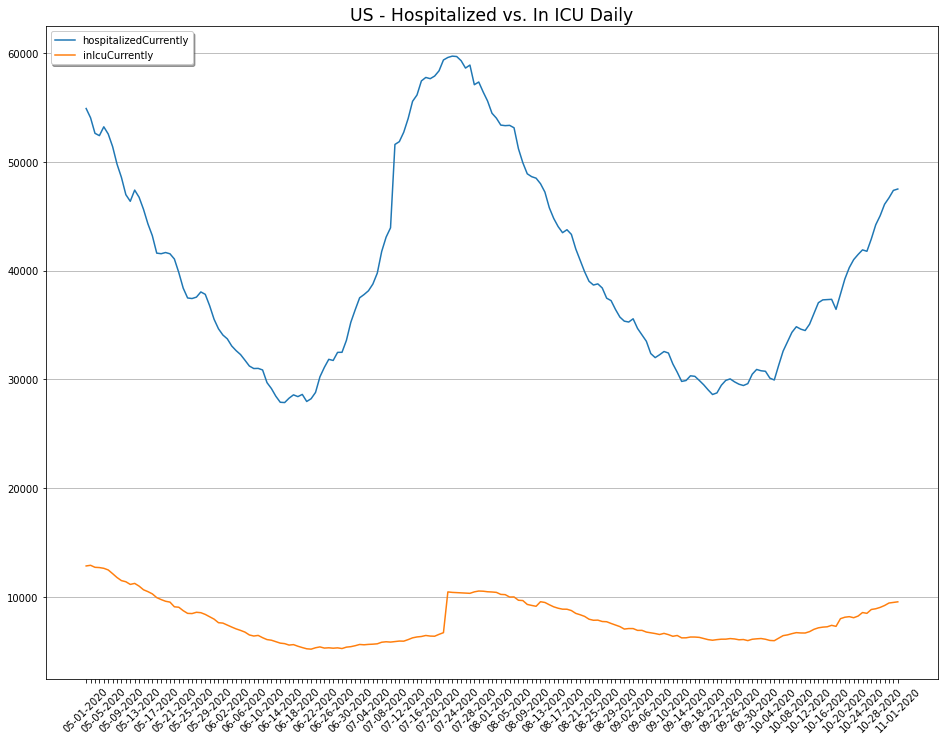

Looking here!
#################### - FL - ####################


/Users/schwim/.pyenv/versions/3.8.5/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/schwim/.pyenv/versions/3.8.5/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


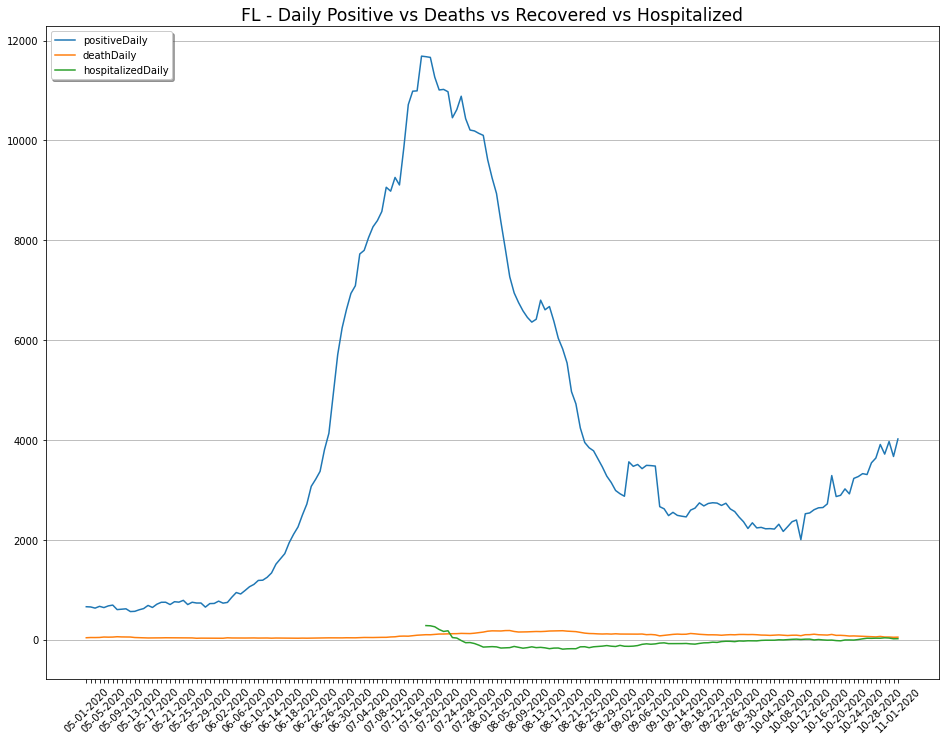

#################### - FL - ####################


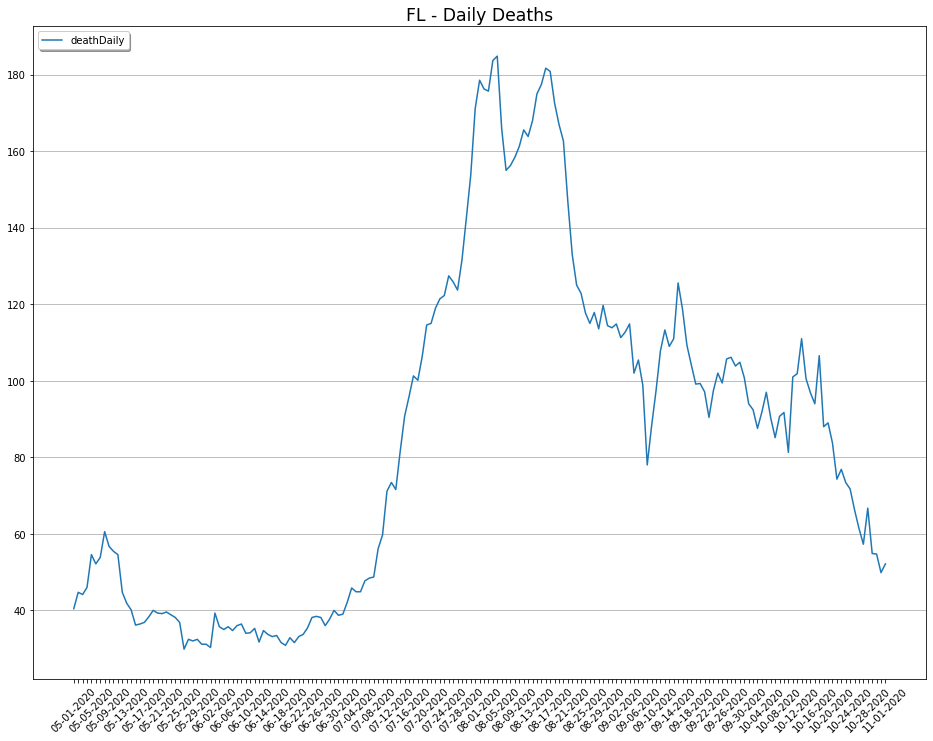

#################### - FL - ####################


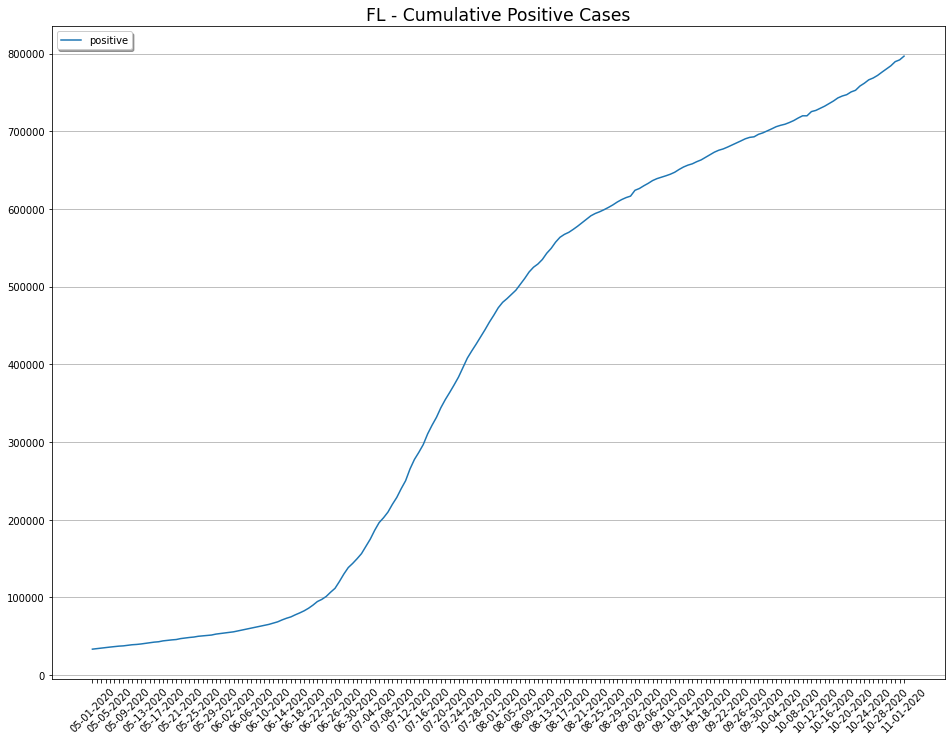

#################### - FL - ####################


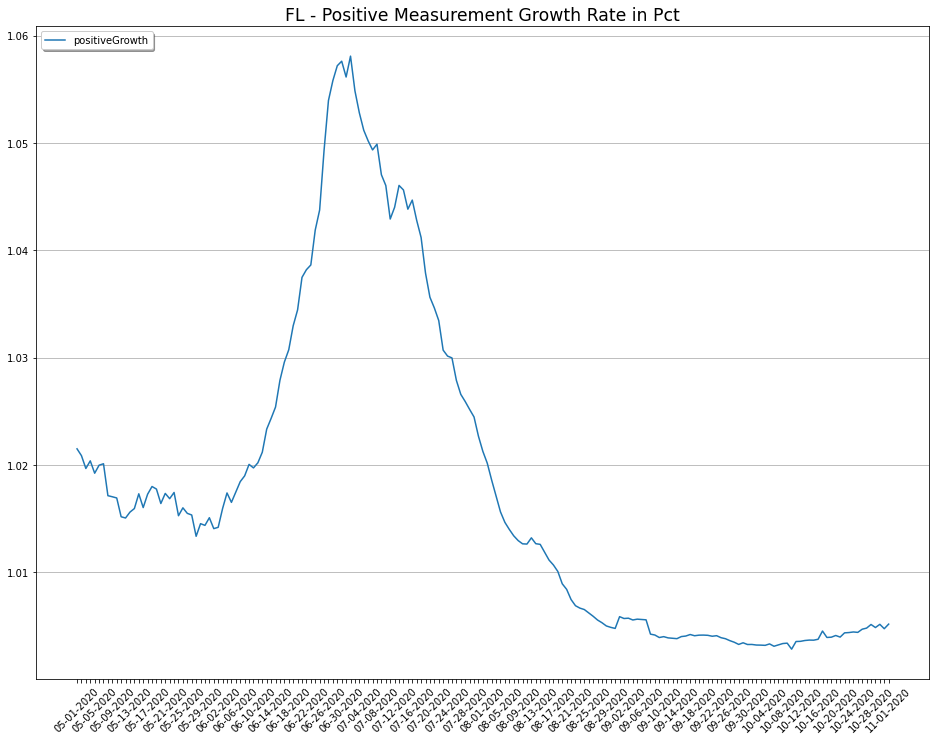

#################### - FL - ####################


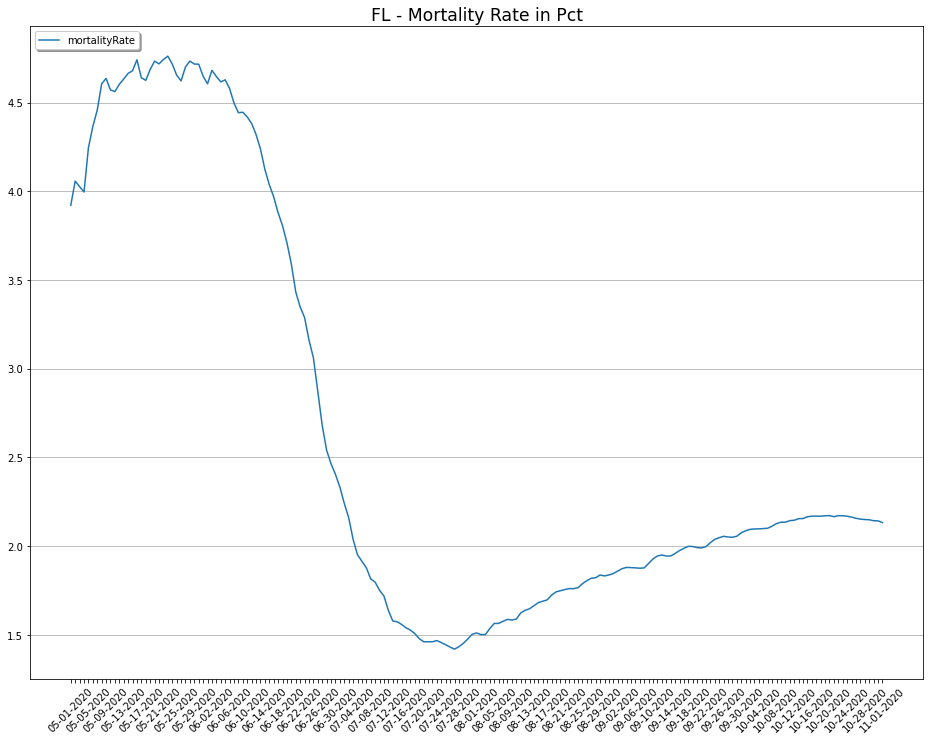

#################### - FL - ####################


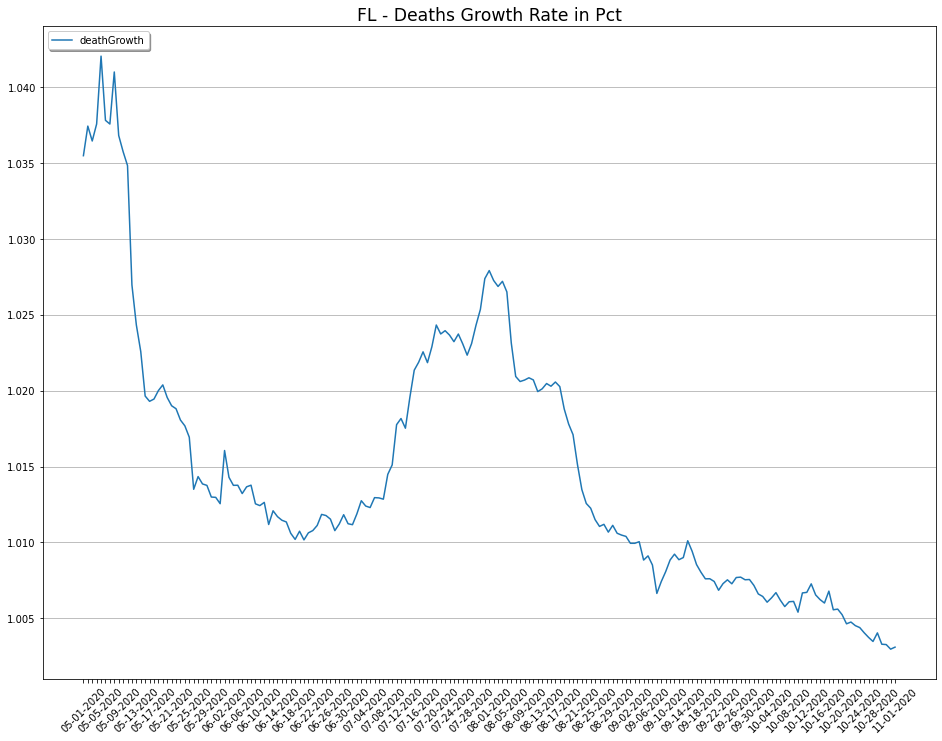

#################### - FL - ####################


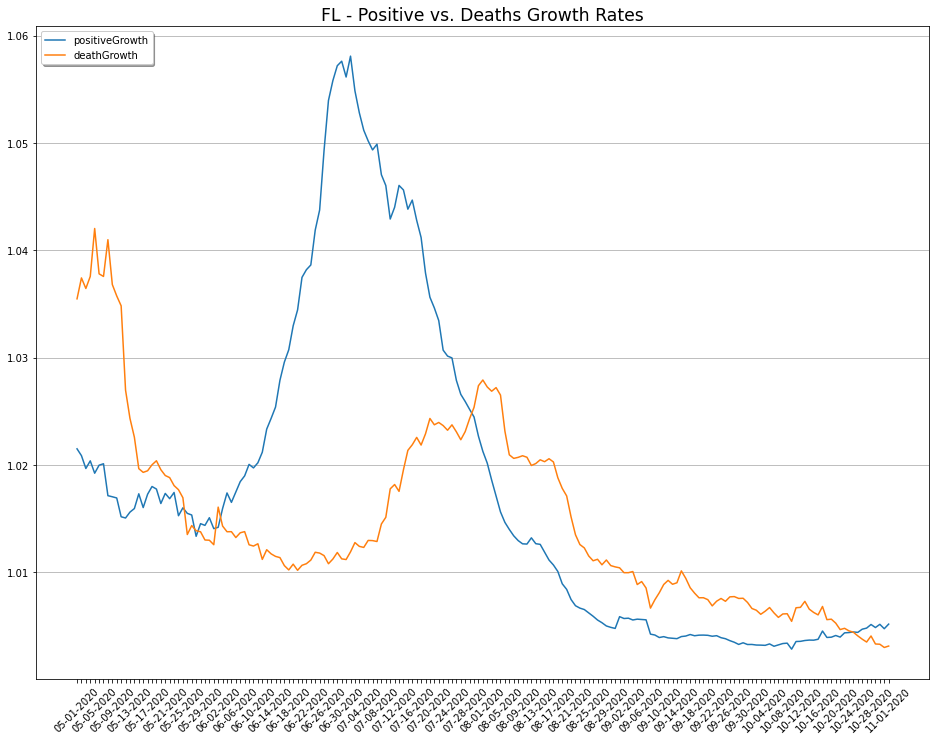

#################### - FL - ####################


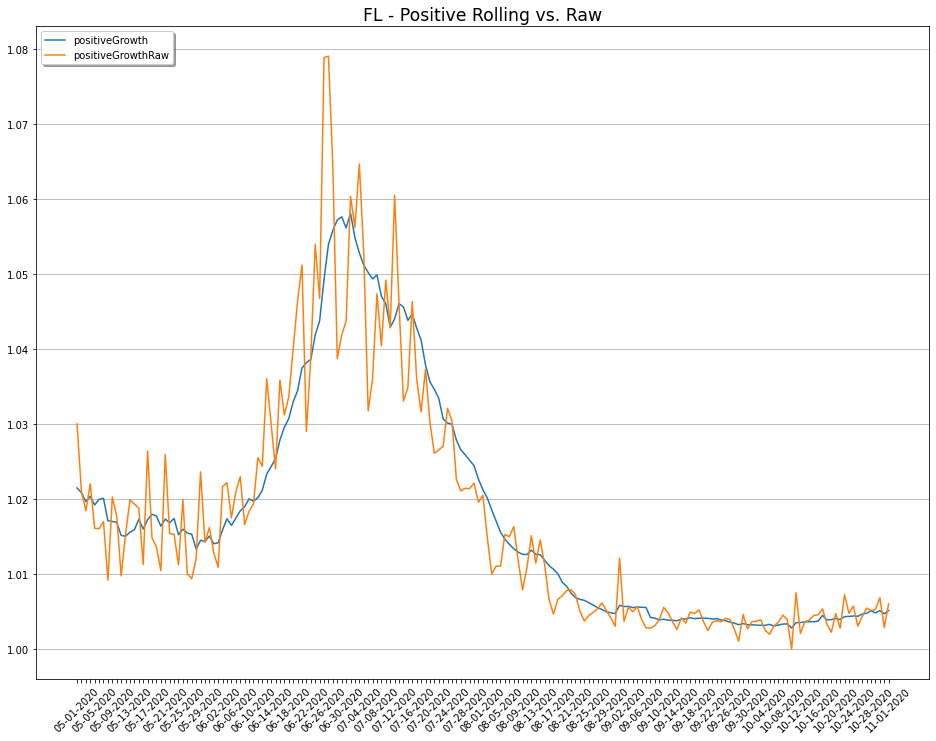

#################### - FL - ####################


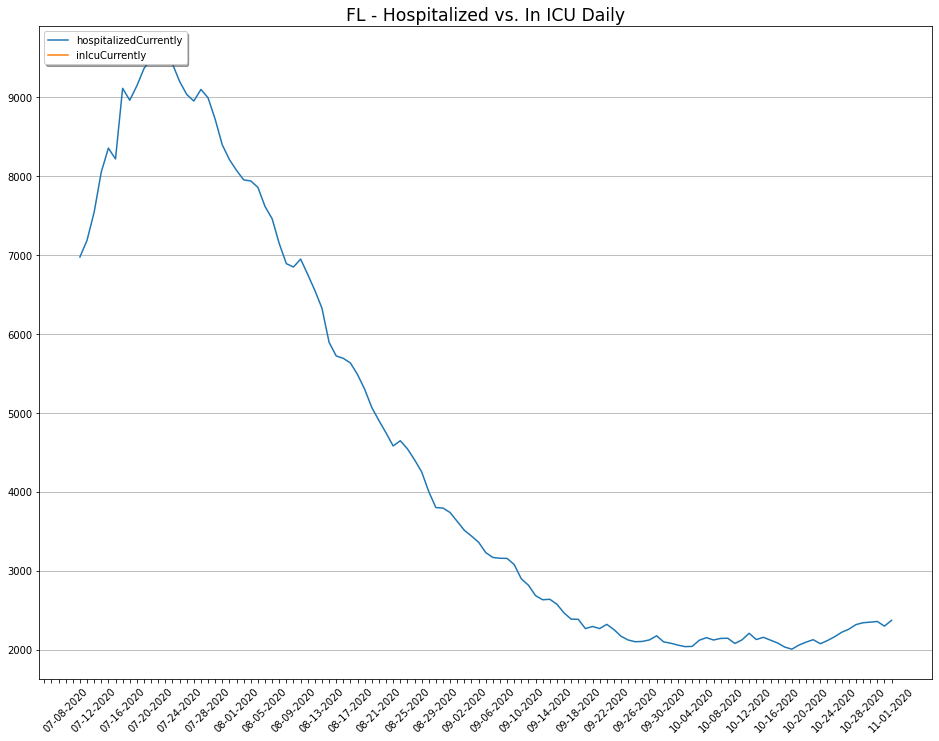

Looking here!
#################### - AZ - ####################


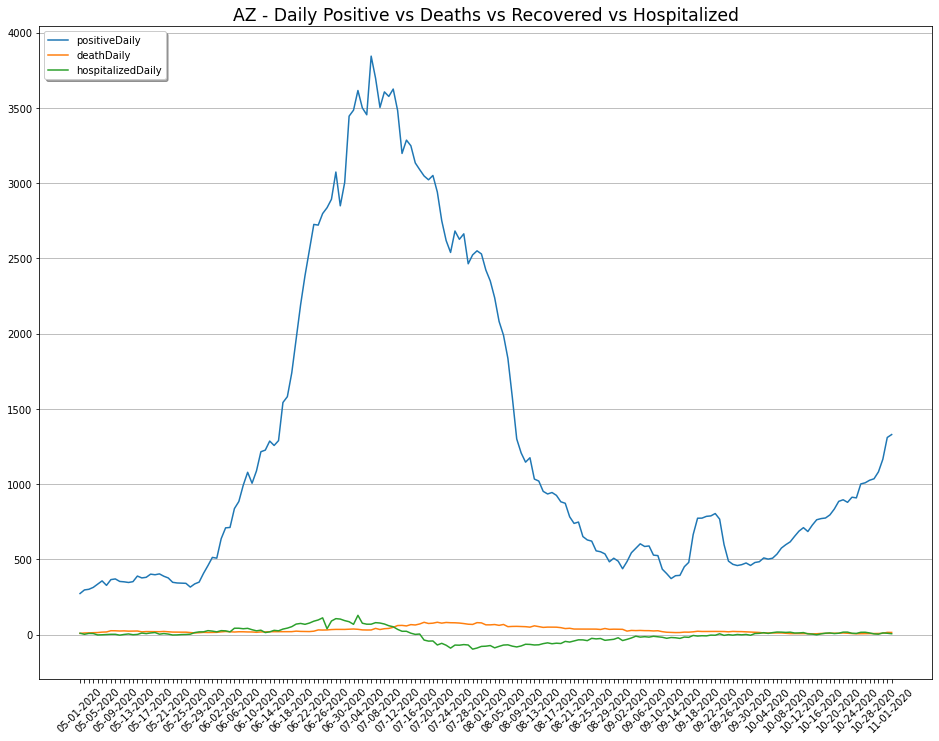

#################### - AZ - ####################


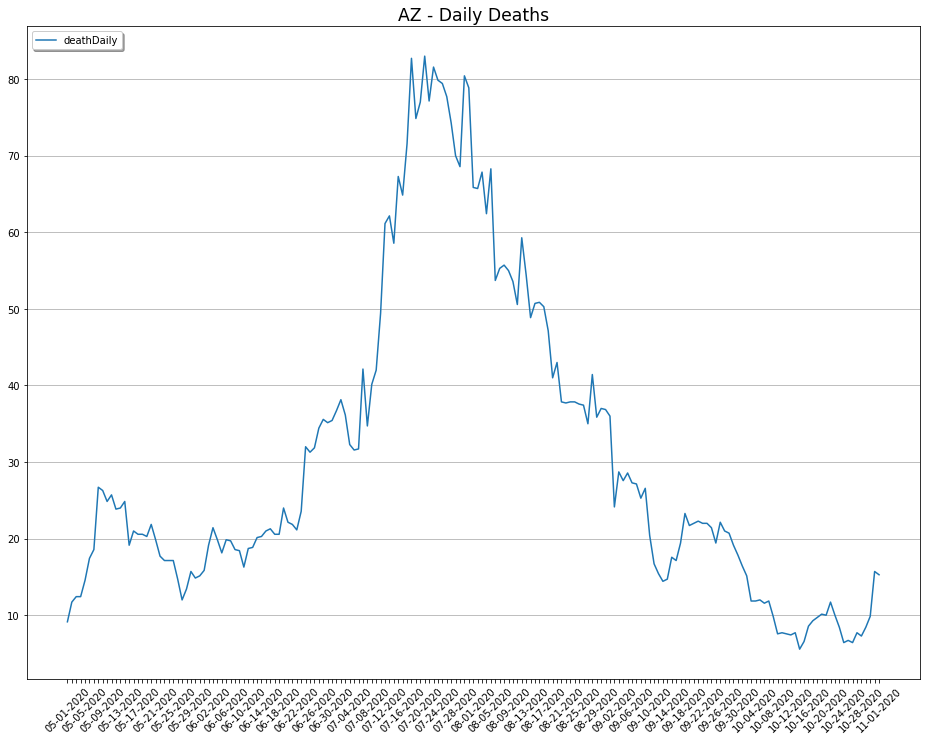

#################### - AZ - ####################


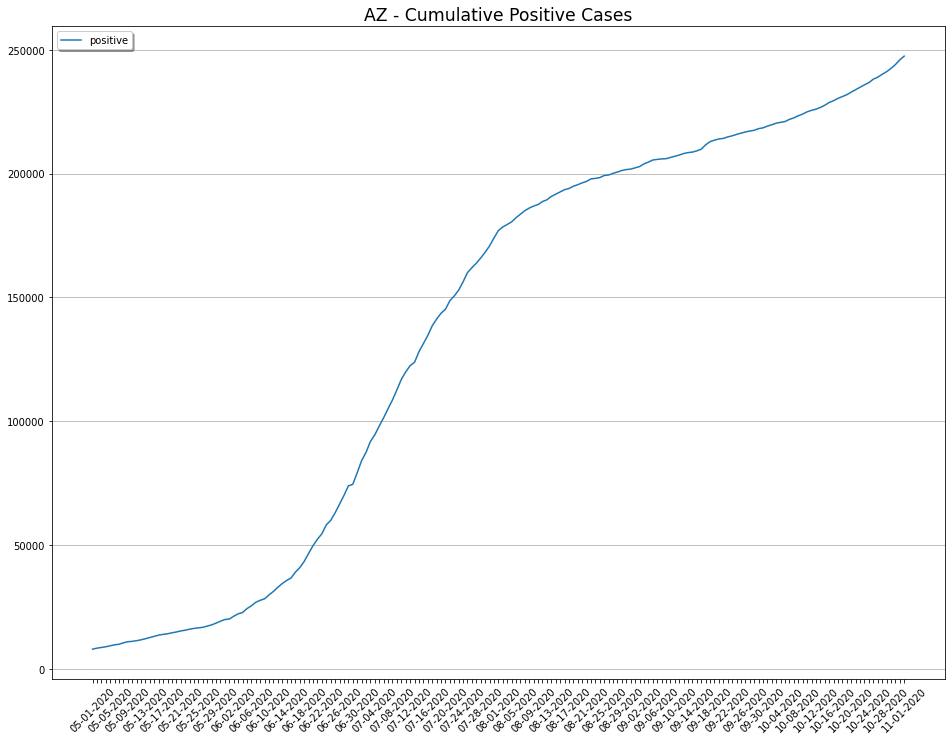

#################### - AZ - ####################


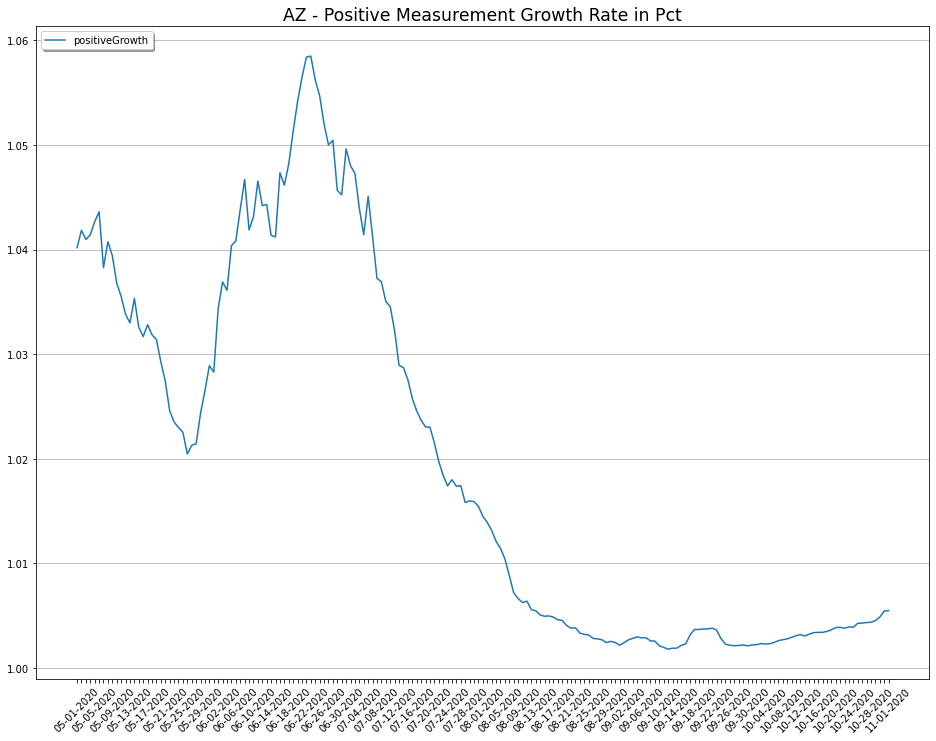

#################### - AZ - ####################


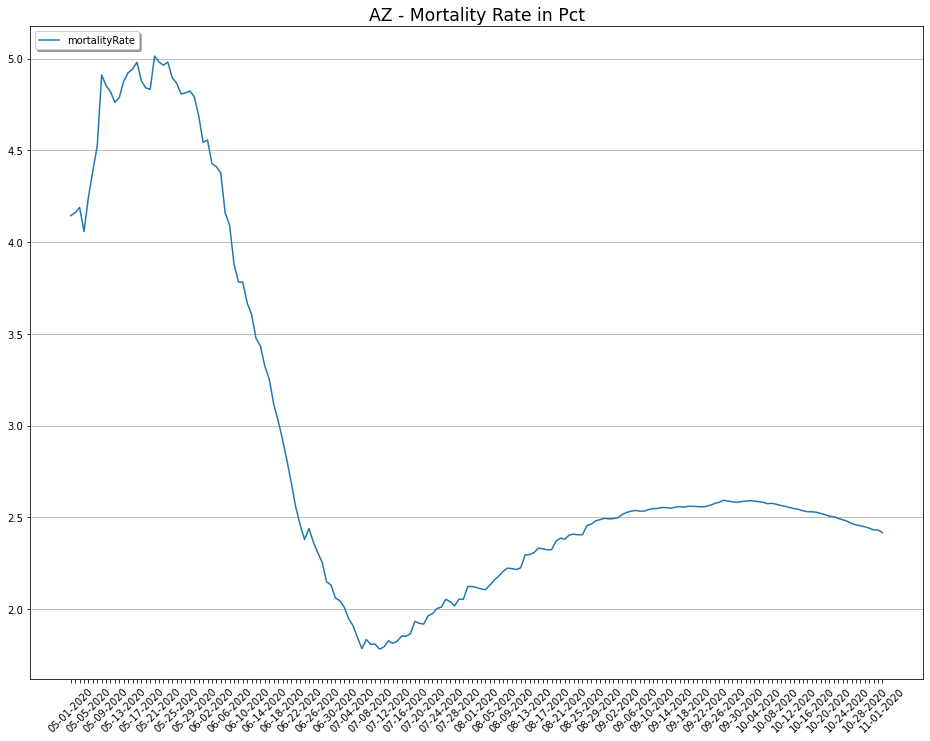

#################### - AZ - ####################


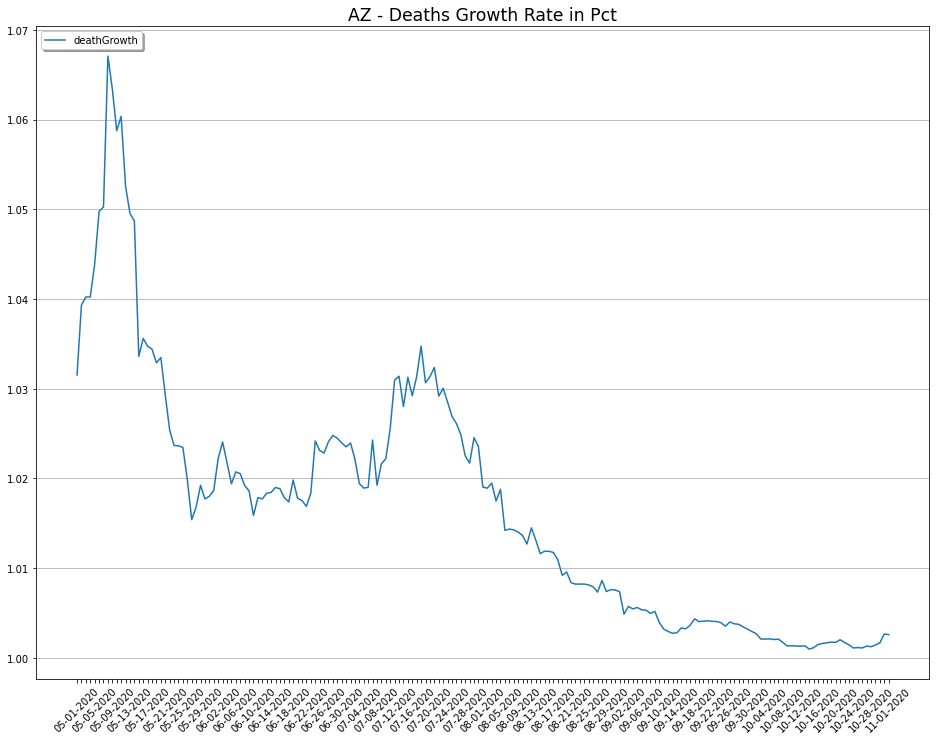

#################### - AZ - ####################


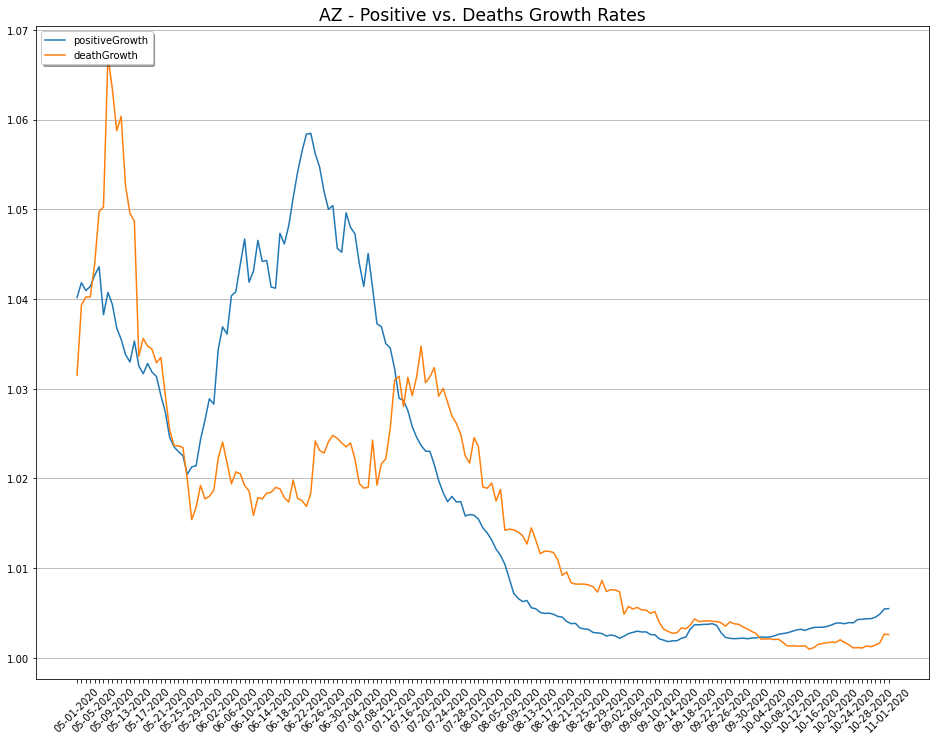

#################### - AZ - ####################


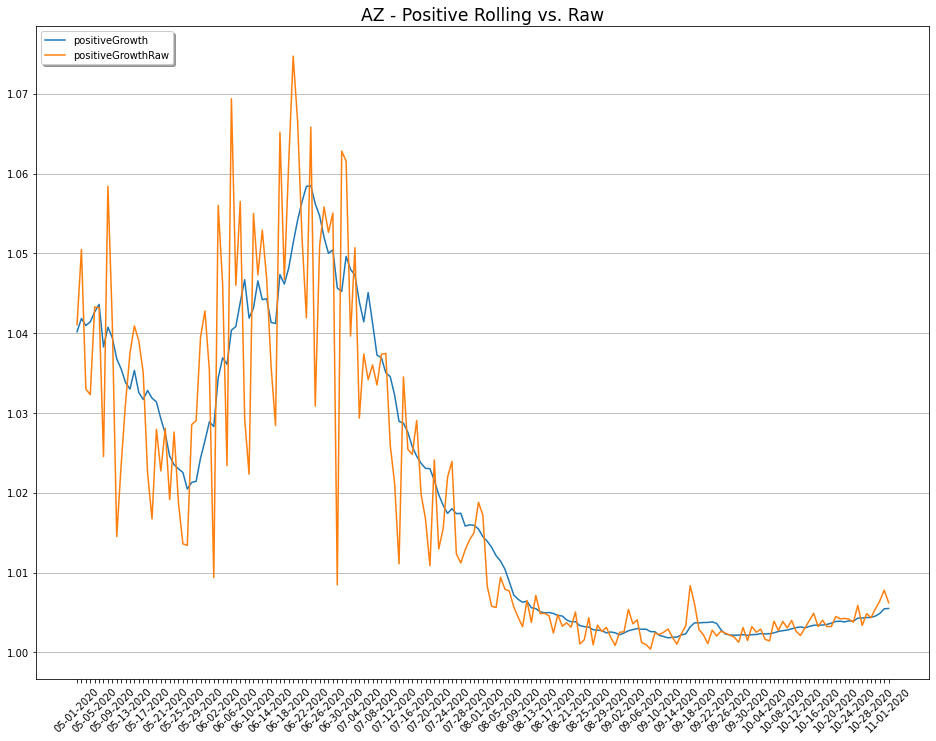

#################### - AZ - ####################


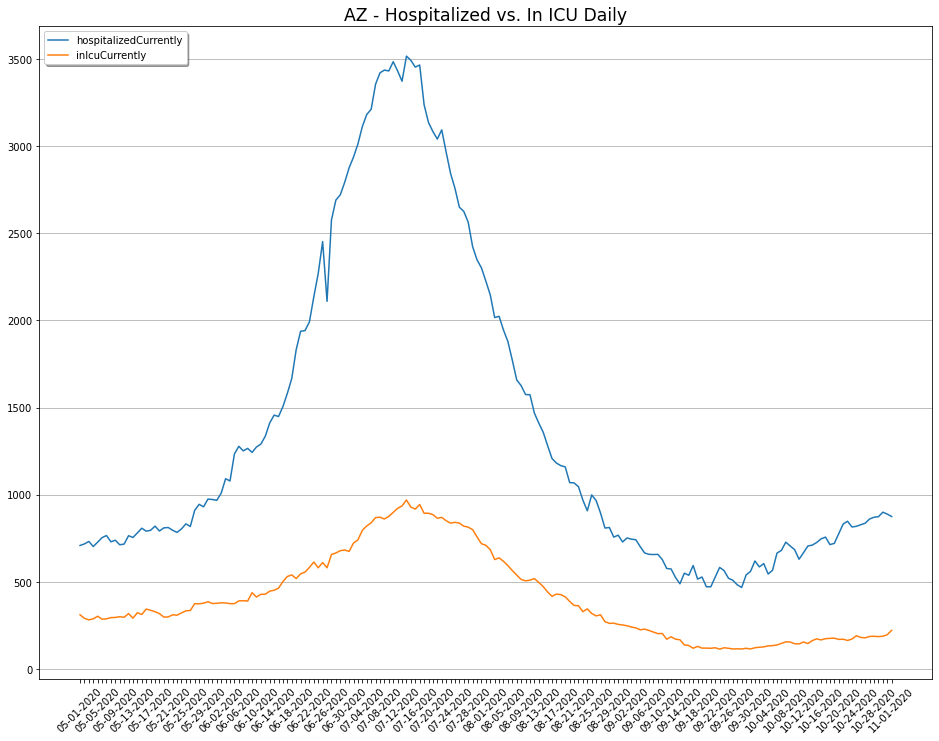

Looking here!
#################### - CA - ####################


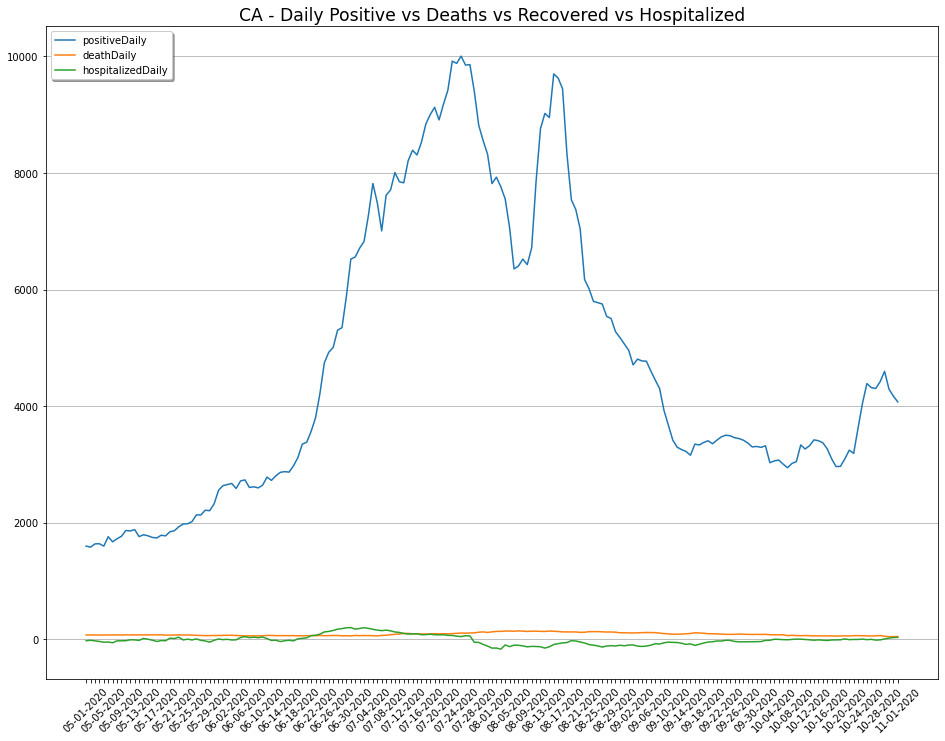

#################### - CA - ####################


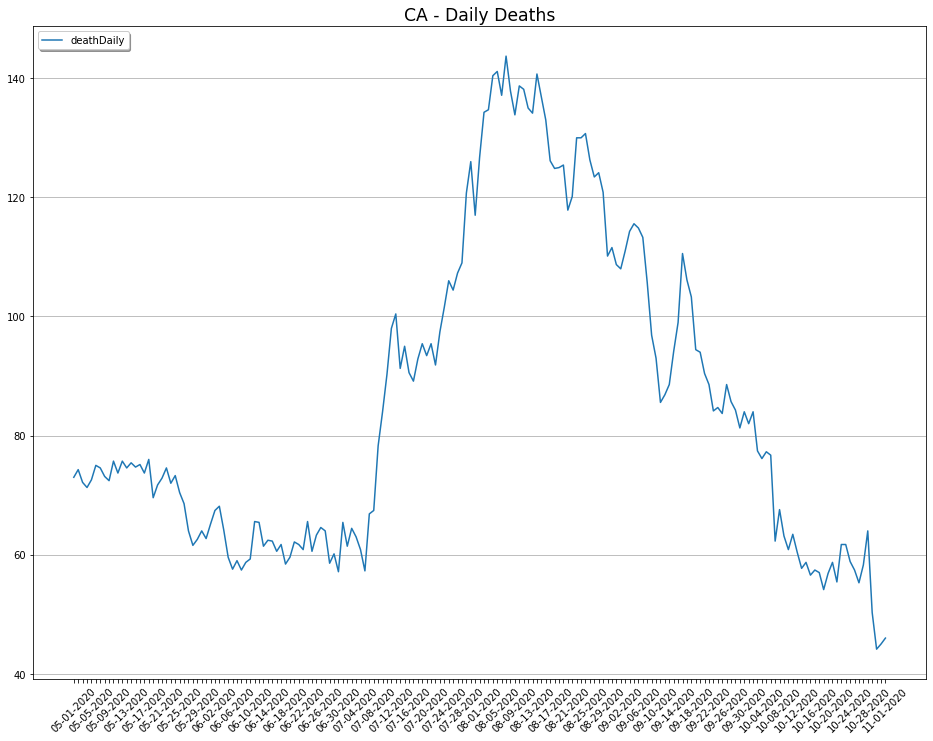

#################### - CA - ####################


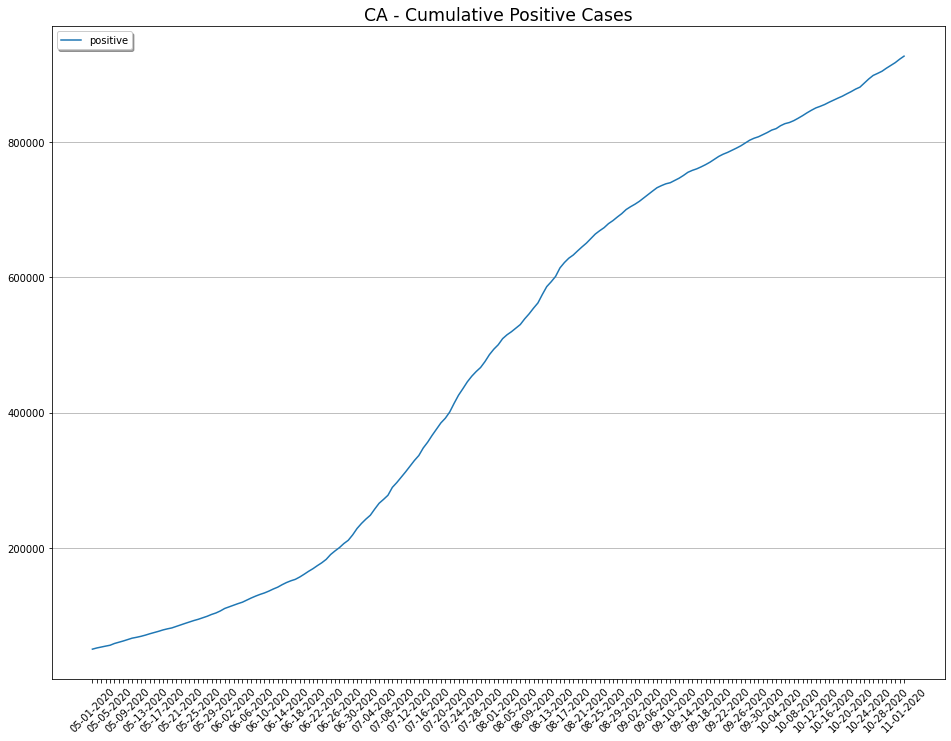

#################### - CA - ####################


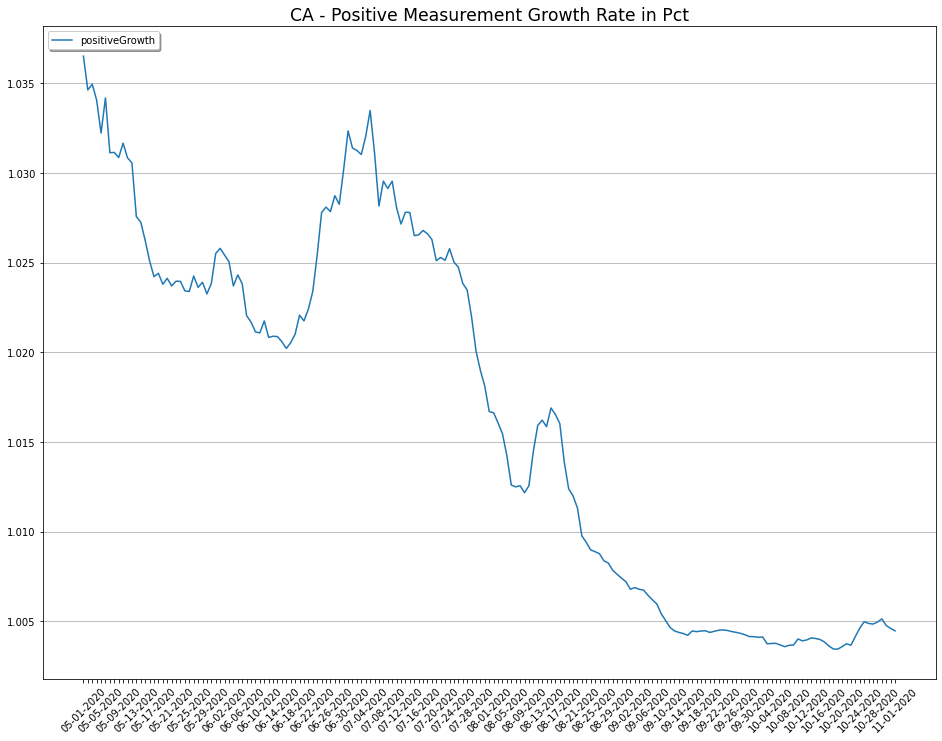

#################### - CA - ####################


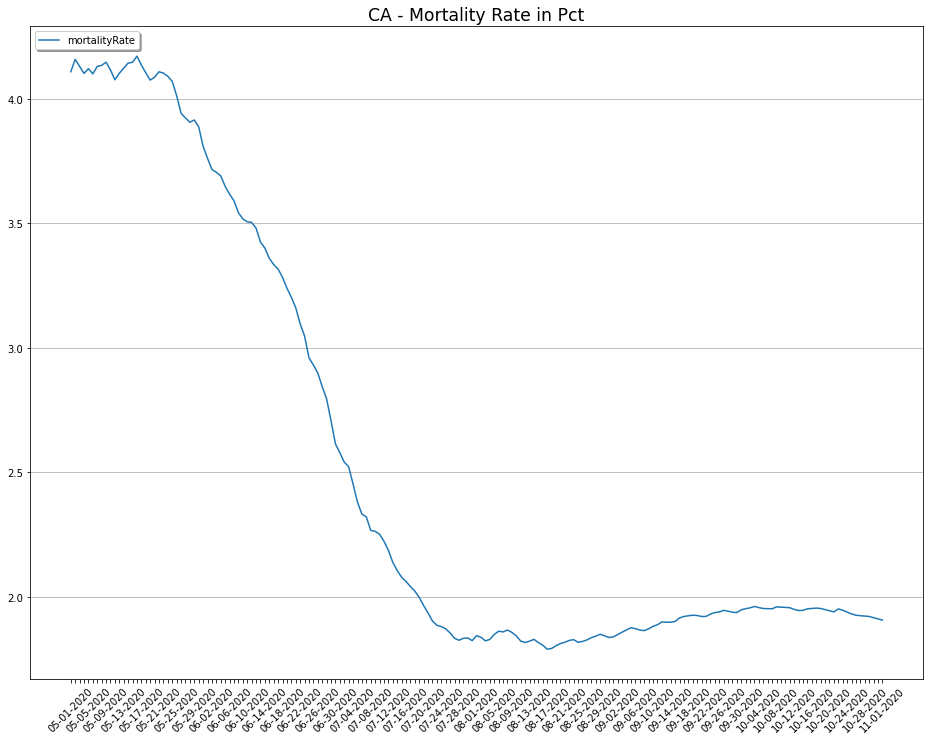

#################### - CA - ####################


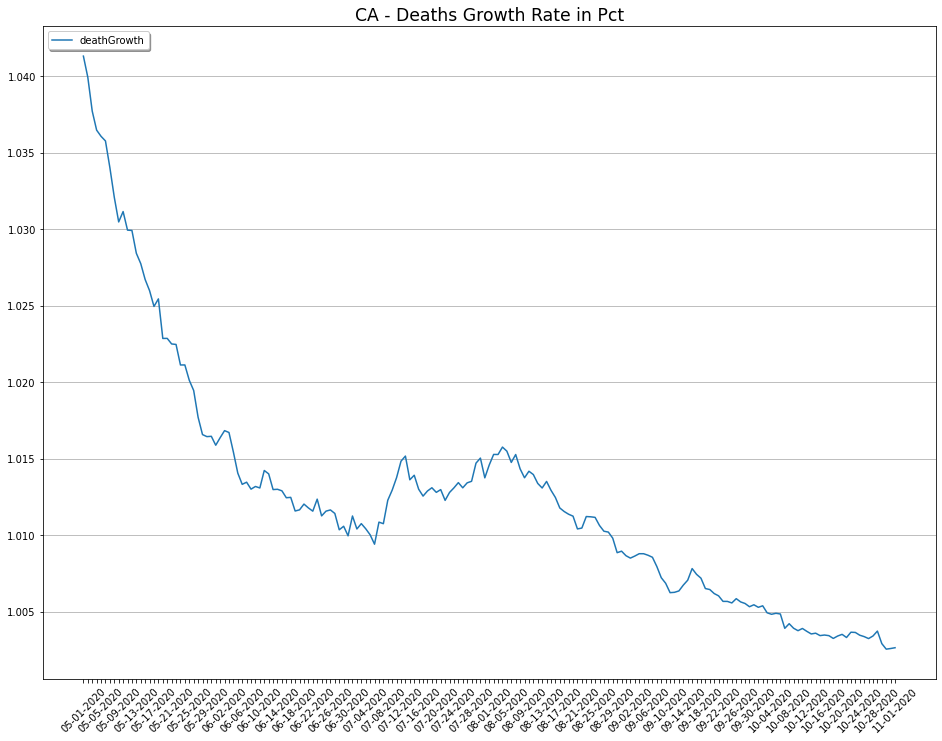

#################### - CA - ####################


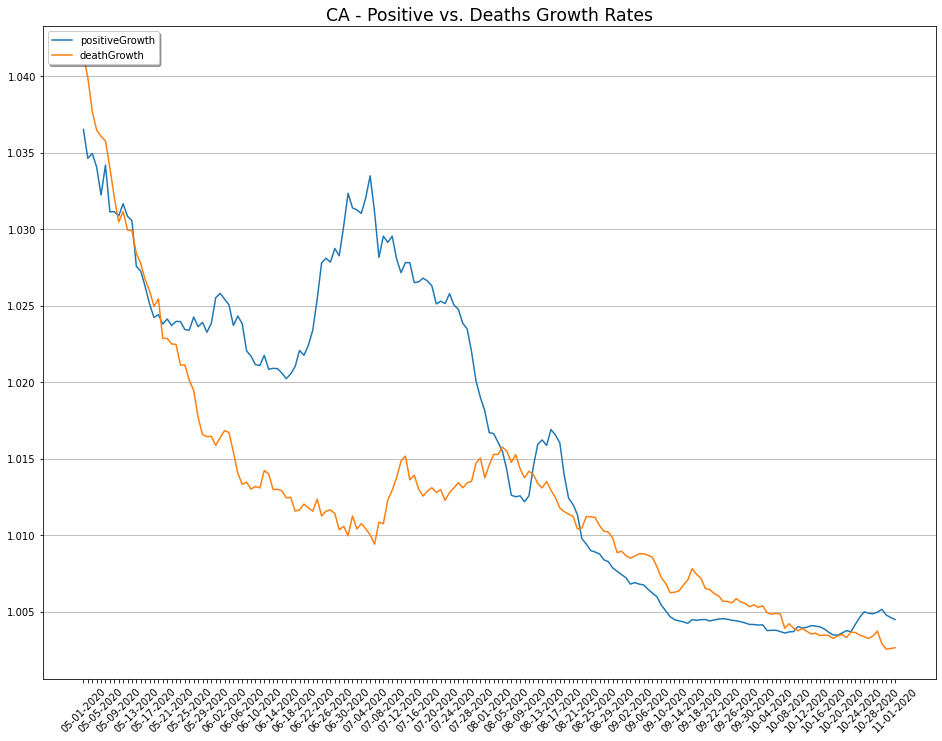

#################### - CA - ####################


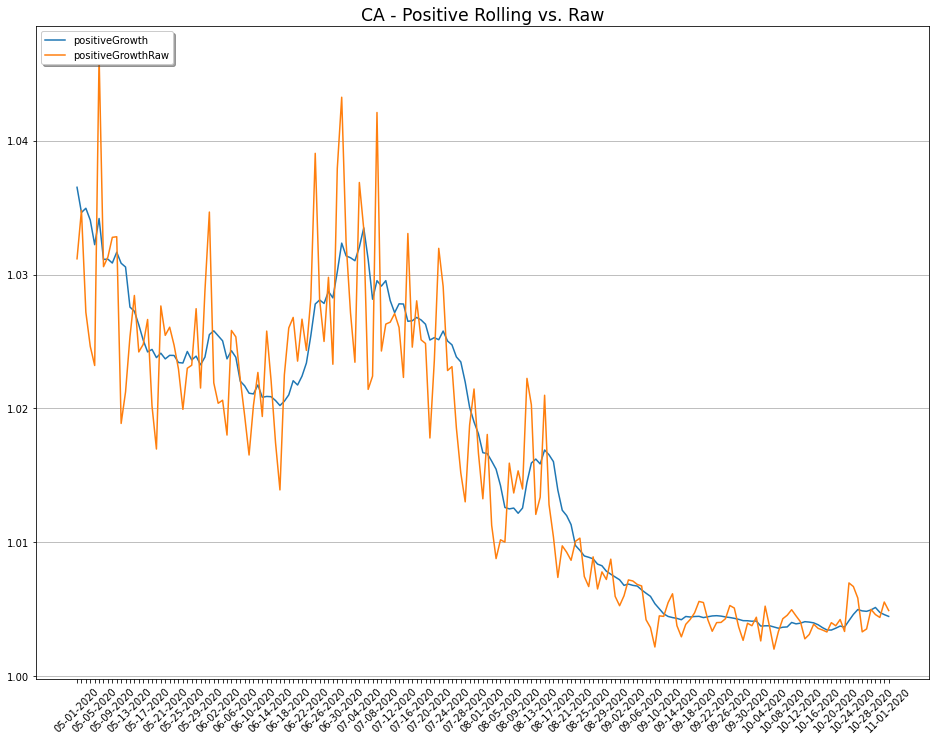

#################### - CA - ####################


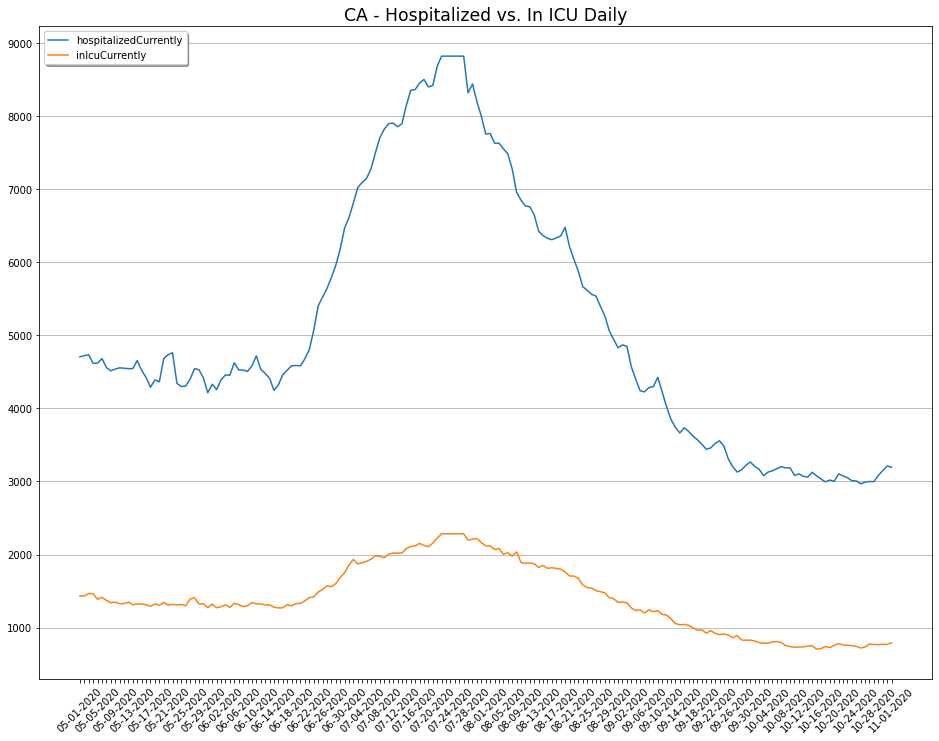

Looking here!
#################### - TX - ####################


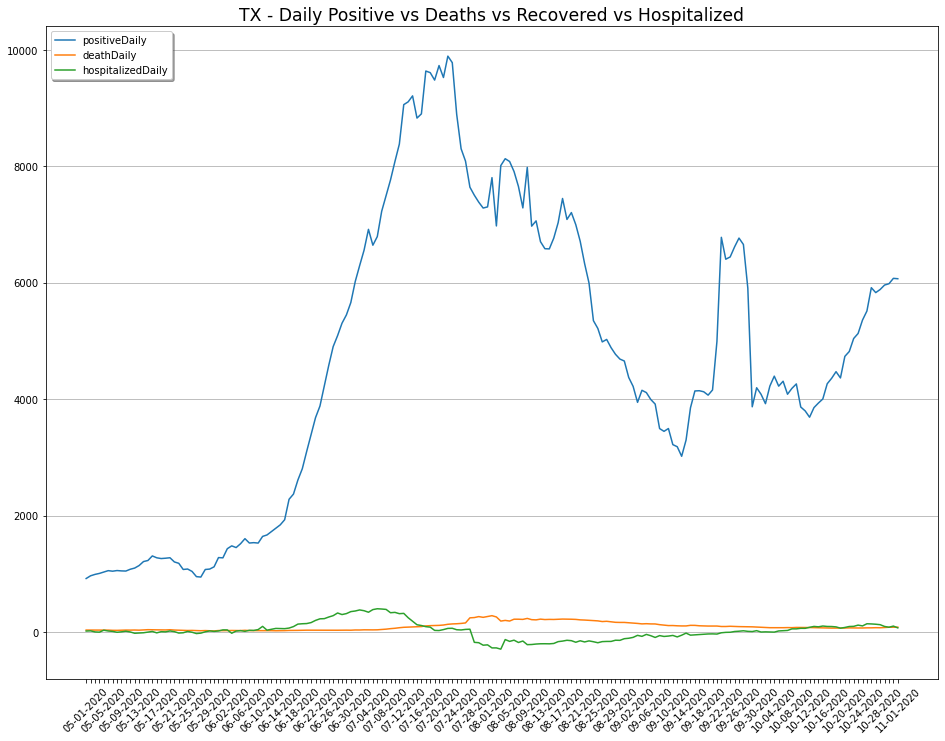

#################### - TX - ####################


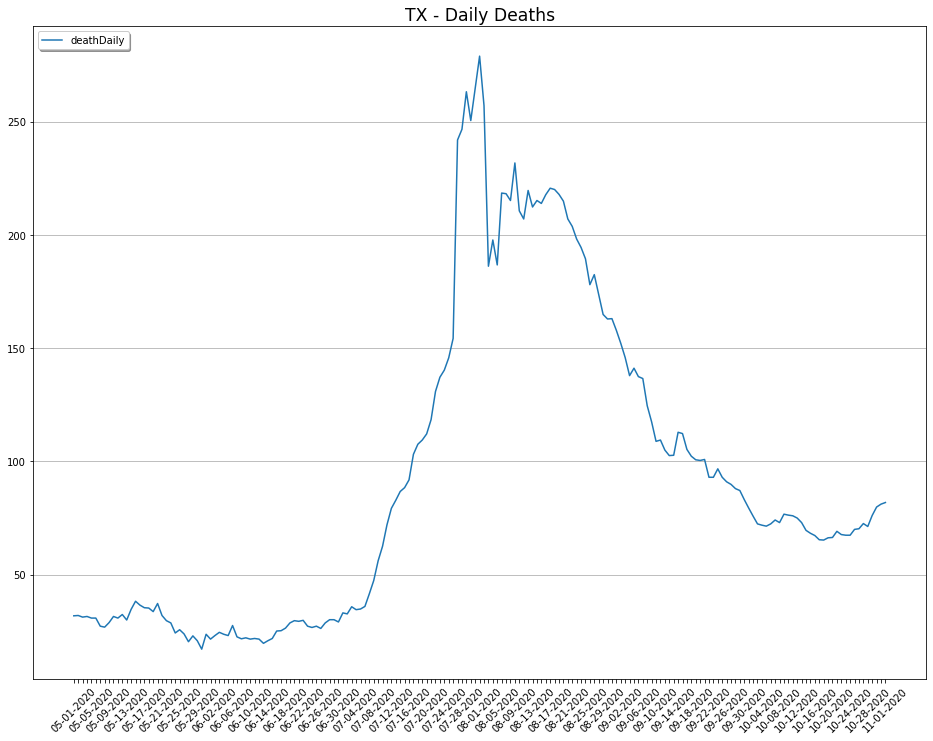

#################### - TX - ####################


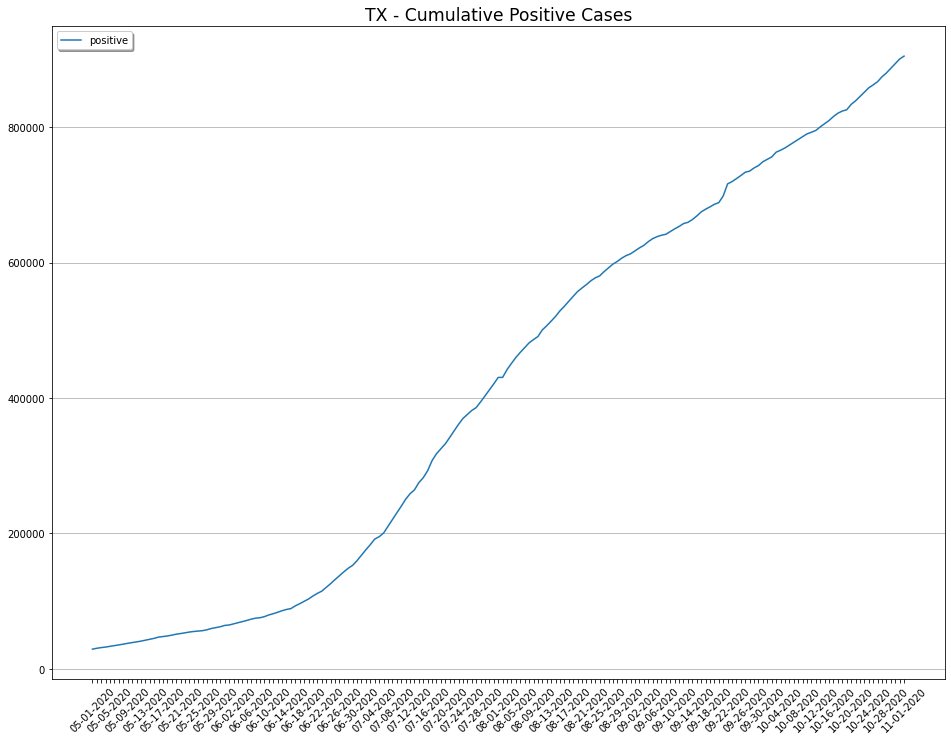

#################### - TX - ####################


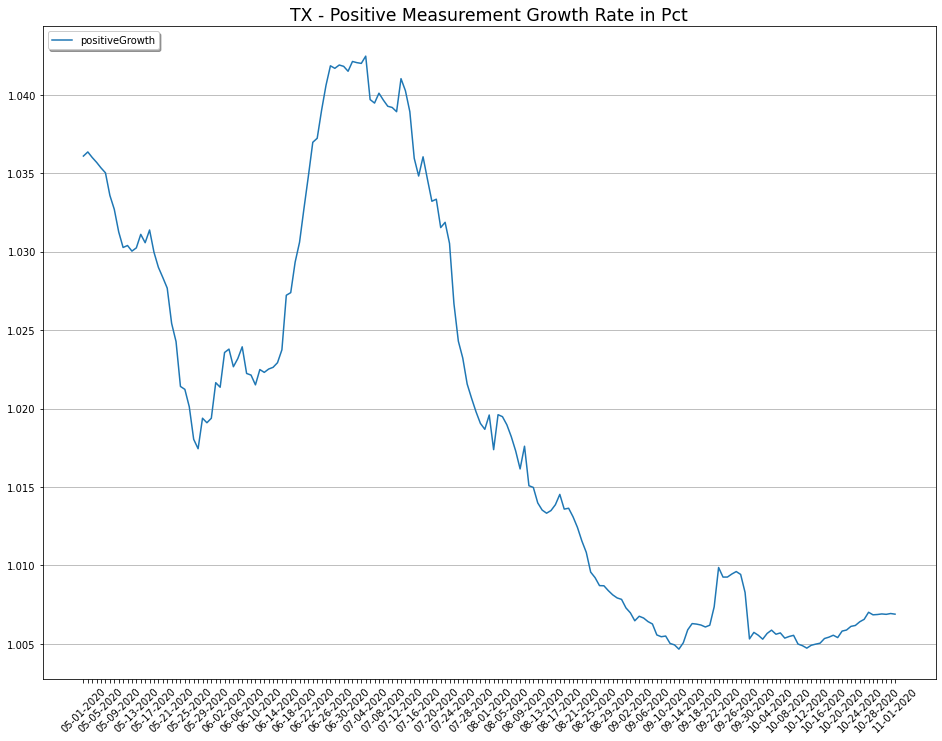

#################### - TX - ####################


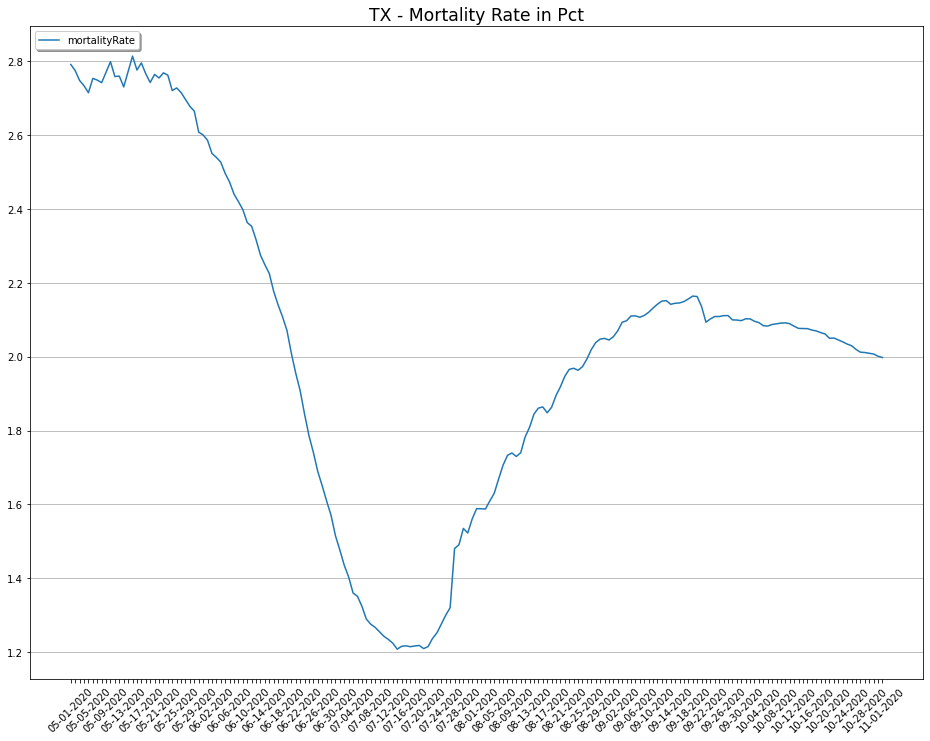

#################### - TX - ####################


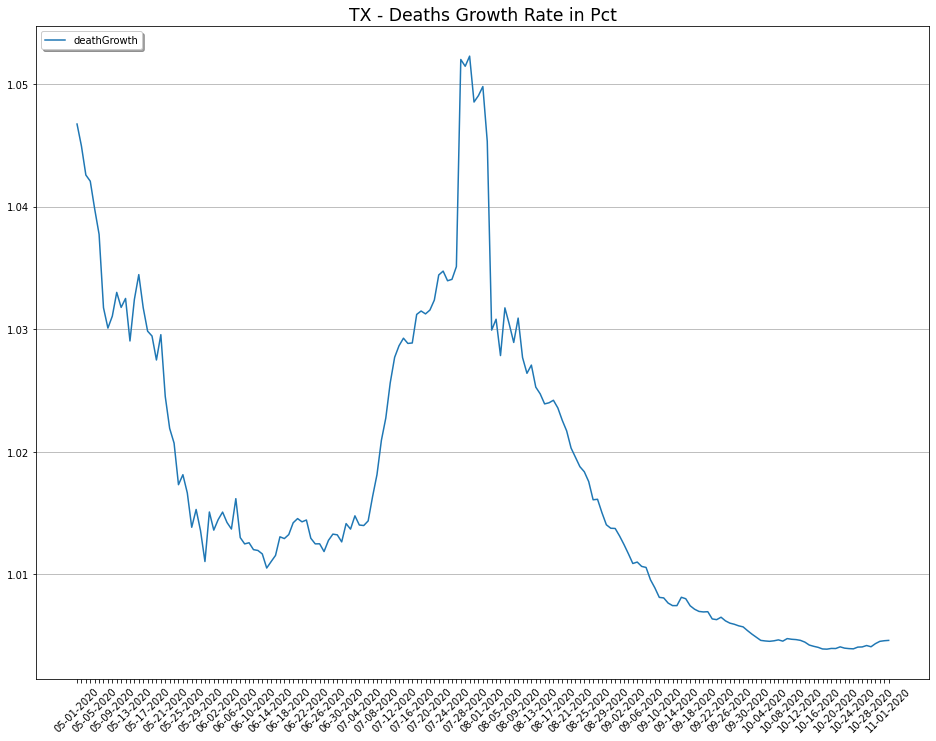

#################### - TX - ####################


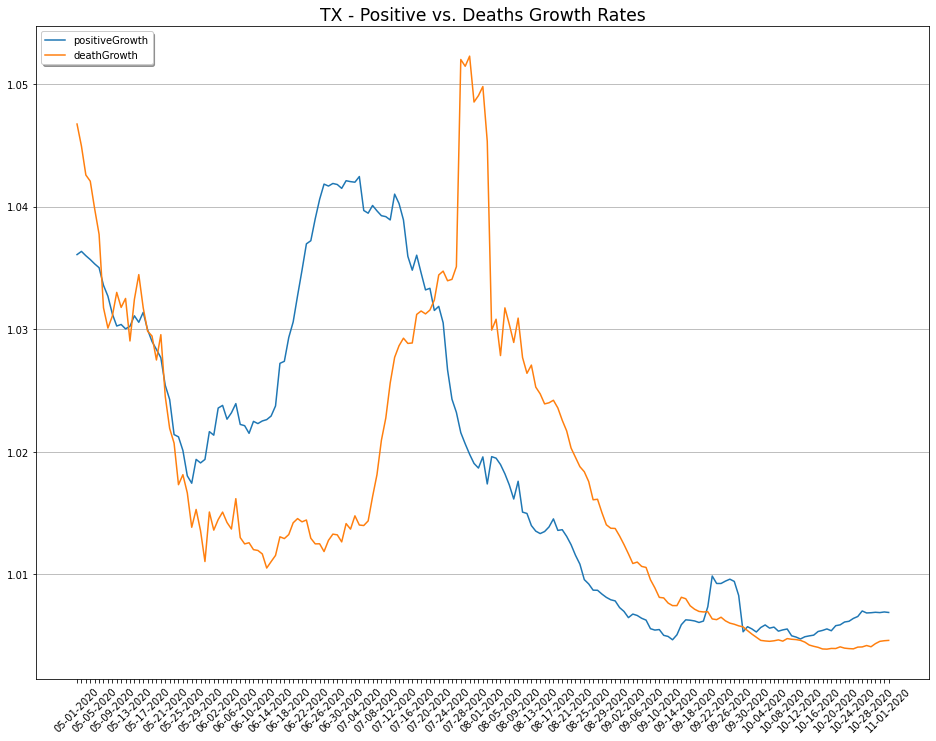

#################### - TX - ####################


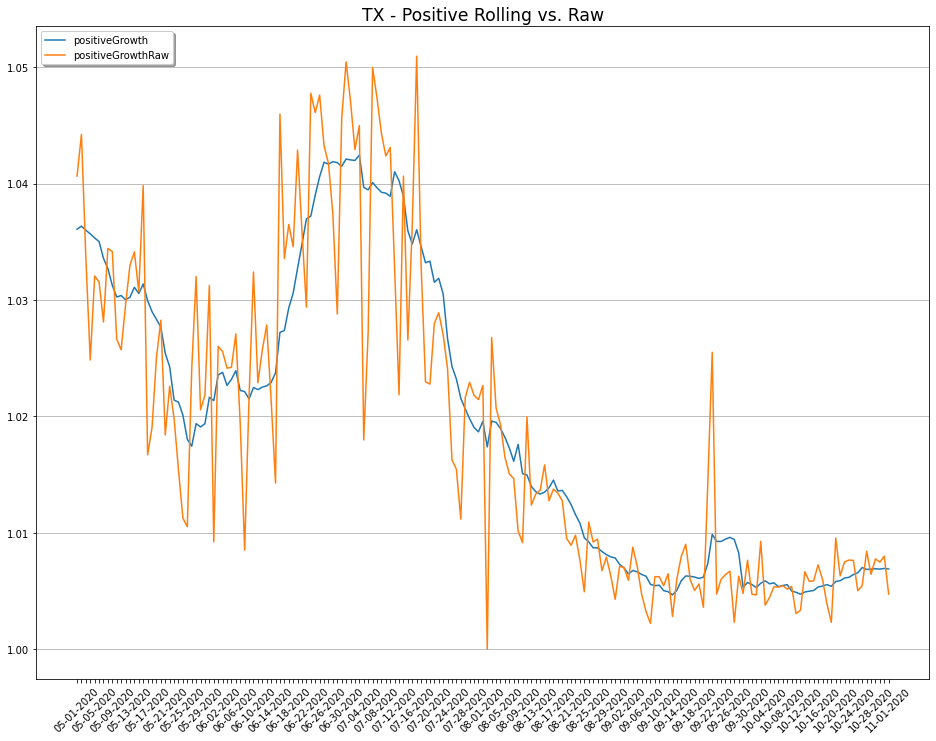

#################### - TX - ####################


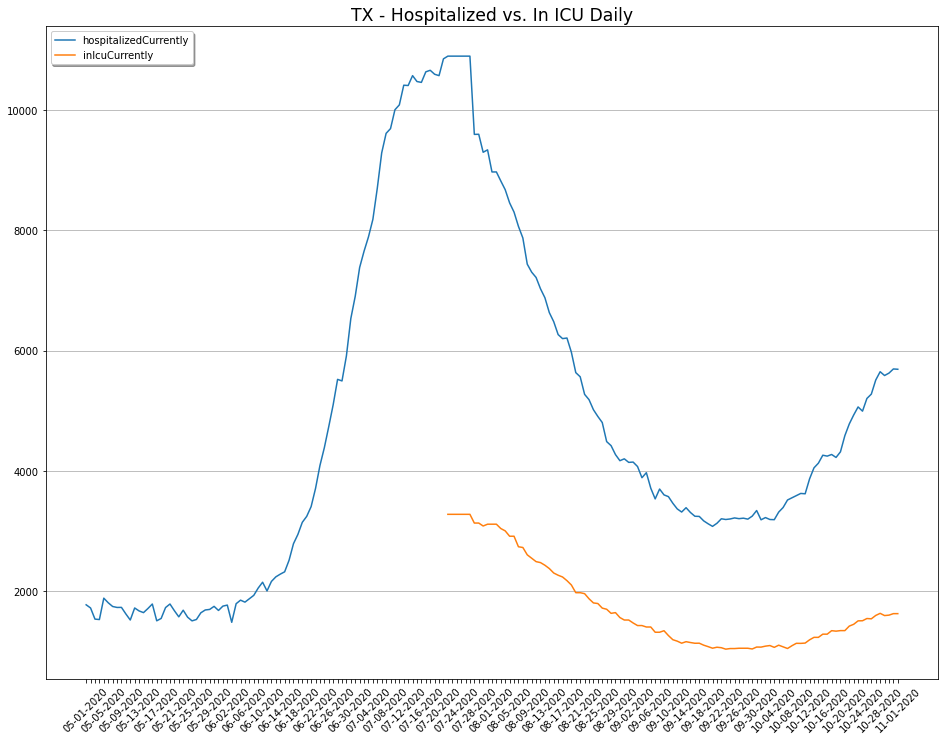

In [5]:
# Do we report all states, or set a region of interest (ROI)


reports = {
    # 'Cumulative Postive vs. Deaths vs. Recovered vs Hospitalized' : ['positive', 'death', 'recovered', 'hospitalizedCumulative'],
    'Daily Positive vs Deaths vs Recovered vs Hospitalized' : ['positiveDaily', 'deathDaily', 'hospitalizedDaily'],
    'Daily Deaths' : ['deathDaily'],
    'Cumulative Positive Cases': ['positive'],
    'Positive Measurement Growth Rate in Pct': ['positiveGrowth'],
    'Mortality Rate in Pct': ['mortalityRate'],
    'Deaths Growth Rate in Pct' : ['deathGrowth'],
    'Positive vs. Deaths Growth Rates': ['positiveGrowth', 'deathGrowth'],
    'Positive Rolling vs. Raw': ['positiveGrowth', 'positiveGrowthRaw'],
    'Hospitalized vs. In ICU Daily': ['hospitalizedCurrently','inIcuCurrently']
}

compReports = {'Daily Deaths Per 1M': ['deathDailyPer1M']}

positiveAll = pd.DataFrame()
positiveGrowthAll = pd.DataFrame()

for x, location in enumerate(states):
    if 'US' in location:
        states[location].loc[:, 'state'] = location
        

    if reportAll is True:
        states[location] = makeStats(data=states[location], state_info=state_info)

        makeReport(reports=reports, data=states[location], start_date=start_date)
        positiveAll.loc[:, location] = states[location].positiveDaily
        positiveGrowthAll.loc[:, location] = states[location].positiveGrowth

    elif location in roi:
        print('Looking here!')
        states[location] = makeStats(data=states[location])

        makeReport(reports=reports, data=states[location], start_date=start_date)
        positiveAll.loc[:, location] = states[location].positiveDaily
        positiveGrowthAll.loc[:, location] = states[location].positiveGrowth

        
allStates = pd.DataFrame()

for x, location in enumerate(states):
    allStates = allStates.append(states[location])
    
allStates = allStates.groupby(by='state')

    

#makeStatesCompareReport(reports=compReports, data=statesToCompare, start_date=start_date)


In [6]:
# state = 'TX'
# (states[state].deathDaily / (state_info.T[state].values / 1000000)).sum()

In [7]:
states['CA'].columns

Index(['state', 'positive', 'probableCases', 'negative', 'pending',
       'totalTestResultsSource', 'totalTestResults', 'hospitalizedCurrently',
       'hospitalizedCumulative', 'inIcuCurrently', 'inIcuCumulative',
       'onVentilatorCurrently', 'onVentilatorCumulative', 'recovered',
       'dataQualityGrade', 'lastUpdateEt', 'dateModified', 'checkTimeEt',
       'death', 'hospitalized', 'dateChecked', 'totalTestsViral',
       'positiveTestsViral', 'negativeTestsViral', 'positiveCasesViral',
       'deathConfirmed', 'deathProbable', 'totalTestEncountersViral',
       'totalTestsPeopleViral', 'totalTestsAntibody', 'positiveTestsAntibody',
       'negativeTestsAntibody', 'totalTestsPeopleAntibody',
       'positiveTestsPeopleAntibody', 'negativeTestsPeopleAntibody',
       'totalTestsPeopleAntigen', 'positiveTestsPeopleAntigen',
       'totalTestsAntigen', 'positiveTestsAntigen', 'fips', 'positiveIncrease',
       'negativeIncrease', 'total', 'totalTestResultsIncrease', 'posNeg',
    

In [8]:
states['AZ']['death'] / (states['AZ']['positive'] * 10)

date
03-04-2020         NaN
03-05-2020         NaN
03-06-2020         NaN
03-07-2020         NaN
03-08-2020         NaN
                ...   
10-28-2020    0.002449
10-29-2020    0.002441
10-30-2020    0.002432
10-31-2020    0.002431
11-01-2020    0.002417
Length: 243, dtype: float64

In [9]:
(states['AZ'].death - states['AZ'].death.shift()).tail(15)

date
10-18-2020     3.0
10-19-2020     3.0
10-20-2020     7.0
10-21-2020    17.0
10-22-2020     5.0
10-23-2020     6.0
10-24-2020     4.0
10-25-2020     5.0
10-26-2020     1.0
10-27-2020    16.0
10-28-2020    14.0
10-29-2020    13.0
10-30-2020    16.0
10-31-2020    45.0
11-01-2020     2.0
Name: death, dtype: float64

In [10]:
(states['AZ'].positive - states['AZ'].positive.shift()).tail(20)

date
10-13-2020     684.0
10-14-2020     901.0
10-15-2020    1113.0
10-16-2020     738.0
10-17-2020     921.0
10-18-2020     742.0
10-19-2020     748.0
10-20-2020    1040.0
10-21-2020     975.0
10-22-2020     994.0
10-23-2020     976.0
10-24-2020     890.0
10-25-2020    1391.0
10-26-2020     801.0
10-27-2020    1158.0
10-28-2020    1043.0
10-29-2020    1315.0
10-30-2020    1565.0
10-31-2020    1901.0
11-01-2020    1527.0
Name: positive, dtype: float64

In [11]:
states['AZ'].positiveGrowthRaw.tail(20)

date
10-13-2020    1.003026
10-14-2020    1.003974
10-15-2020    1.004889
10-16-2020    1.003226
10-17-2020    1.004013
10-18-2020    1.003220
10-19-2020    1.003236
10-20-2020    1.004485
10-21-2020    1.004186
10-22-2020    1.004249
10-23-2020    1.004155
10-24-2020    1.003773
10-25-2020    1.005875
10-26-2020    1.003363
10-27-2020    1.004846
10-28-2020    1.004344
10-29-2020    1.005453
10-30-2020    1.006454
10-31-2020    1.007790
11-01-2020    1.006209
Name: positiveGrowthRaw, dtype: float64

In [12]:
(states['AZ'].negative - states['AZ'].negative.shift()).tail()

date
10-28-2020     5774.0
10-29-2020    13013.0
10-30-2020    11912.0
10-31-2020    10684.0
11-01-2020    12748.0
Name: negative, dtype: float64

In [13]:
states['AZ'].positive - states['AZ'].positive.shift()

date
03-04-2020       NaN
03-05-2020       0.0
03-06-2020       1.0
03-07-2020       2.0
03-08-2020       0.0
               ...  
10-28-2020    1043.0
10-29-2020    1315.0
10-30-2020    1565.0
10-31-2020    1901.0
11-01-2020    1527.0
Name: positive, Length: 243, dtype: float64

In [14]:
((500000 - states['US'].death[-1]) / 96) / states['US'].deathDaily[-1]


3.5629074889867844

In [16]:
states['US'].death

date
01-22-2020         NaN
01-23-2020         NaN
01-24-2020         NaN
01-25-2020         NaN
01-26-2020         NaN
                ...   
10-28-2020    219374.0
10-29-2020    220423.0
10-30-2020    221356.0
10-31-2020    222316.0
11-01-2020    222704.0
Name: death, Length: 285, dtype: float64